# Mini-project n°2 - Conditional VAEs

## I) Contexte du projet et présentation des CVAE

### I.1) Présentation du projet

Au cours de ce projet, nous travaillons sur le jeu de données Fashion-MNIST, qui contient des images de vêtements en vente sur Zalando. Les images de vêtements sont séparées dans 10 catégories, selon le type de l'article (T-shirt/top, pantalon, pull-over, robe, manteau, sandales, chemises, baskets, sacs et bottines). Notre objectif est de construire et d'entrainer un réseau de neurone qui nous permette de générer des images d'un certain type d'article voulu.

Au sein du dataset, nous avons un jeu d'entrainement contenant 60000 articles, et un jeu de test contenant 10000 articles. Chaque image est en niveau de gris (donc sur un seul canal), de taille $28 \times 28$. Le jeu de données d'entrainement est donc de taille $60000\times 28\times 28$.

### I.2) Présentation des CVAE

Pour générer de nouvelles images, nous pouvons, comme nous l'avons vu en cours, utiliser une structure d'autoencodeur variationnel (VAE). Néanmoins un VAE classique ne permet pas de choisir le type d'article pour lequel on souhaite générer l'image.

Une méthode permettant de résoudre ce problème est le VAE conditionnel (CVAE). Celle-ci à un fonctionnement similaire par rapport au VAE classique, auquel on ajoute des variables conditionnelles (dans notre cas le type de l'article) en plus de l'embedding de l'image en entrée du décodeur. Ainsi, l'image générée dépendera directement de la condition renseignée, et on peut choisir le type d'article à générer.

## II) Définition des fonctions

### Import des librairies

In [16]:
# Libraries
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
import random as rd
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm import tqdm
import time

# On définit l'utilisation du gpu et du cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Définition des hyperparamètres

In [17]:
# A mettre au niveau de la définition des modèles

BATCH_SIZE = 128
LATENT_DIM = 10
LEARNING_RATE = 1e-3
EPOCH = 10 #5
KL_WEIGHT = 1

###  Ouverture du Dataset
Le code suivant charge le MNIST dataset et construit les Dataloader d'entrainement et de test.

In [18]:
# Chargement des données
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='../../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

### Stockage des modèles

Pour plus de flexibilité, les codes suivants vont utiliser des dictionnaires de modèles, facilement manipulable et qui permettront de comparer les modèles au mieux.

In [19]:
# Default initialisation of a model
def config_model(model, latente_dim = 10, lr = 1e-3):
    mod = model(latent_dim=latente_dim)
    mod.to(device)
    optimizer_mod = optim.Adam(mod.parameters(), lr=lr)
    return (mod, optimizer_mod)

In [20]:
# A small function that reinit weights for every models in the dict
def reinit(models_dict):
    for _, (model, __) in models_dict.items():
        for layer in model.children():  # runs through the sub-layers of the model.
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()  # Reset settings if possible
    return None

### Fonction de perte

Nous allons utiliser au cours de ce projet la fonction de perte classique pour les VAE : la fonction de perte ELBO (pour Evidence Lower Bound). Cette dernière se décompose en deux termes :

- Un terme de reconstruction, qui mesure la similarité entre les données originales et les données reconstruites. Il est calculé à partir de l'entropie croisée binaire (BCE - Binary Cross Entropy).
Ce terme est défini comme suit : 
$$BCE(x',x)=-∑_{i=1}^N​[x_i​log(x'_i​)+(1−x_i​)log(1−x'_i​)]$$

où :

* $x$ représente les données d'entrée (les images originales),
* $x'$ représente les données reconstruites par le décodeur,
* $N$ est le nombre de pixels dans l'image.


- Un terme de régularisation, qui pénalise l'écart entre la distribution latente et une distribution normale centrée-réduite. Pour cela, on utilise la divergence de Kullback-Leibler (KLD). Ce terme est important pour que des points proches dans l'espace latent correspondent à des images similaires. Il est défini comme suit :

$$D_{\text{KL}} \left( q(z \mid x) \, \| \, p(z) \right) = -\frac{1}{2} \sum_{j=1}^d \left( 1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2 \right)$$

où :

- $ q(z \mid x) \sim \mathcal{N}(\mu, \sigma^2) $ est la distribution latente paramétrée par le réseau,  
- $ \mu $ et $ \sigma $ sont les paramètres de la distribution latente,  
- $ d $ est la dimension de l'espace latent.

Ainsi, nous cherchons au cours de l'entrainement à reconstruire au mieux les images tout en approchant au maximum la distribtion de l'espace latent d'une loi normale centrée réduite.

In [21]:
# Loss function that also return BCE and KLD separately as well
def loss_function(recon_x, x, mu, logvar, kl_weight=1.0):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + kl_weight * KLD, BCE, KLD

### Codes pour l'entrainement des modèles

On définit une fonction pour entrainer tous les modèle présents dans le dictionnaire

In [22]:
# Training and plotting function
def train(dict_model, train_loader, device, kl_weight=1.0, epochs=30, have_labels = True):
    # If it hasn-t been done before, reset the network weights before each training.
    reinit(dict_model)

    # Dictionary to store evolution losses for each model
    evol_losses = {model_name: [] for model_name in dict_model.keys()}
    evol_bce = {model_name: [] for model_name in dict_model.keys()}
    evol_kl = {model_name: [] for model_name in dict_model.keys()}

    # Training phase over epochs
    for epoch in range(1, epochs + 1):

        # Variables to accumulate losses during the period
        running_losses = {model_name: 0.0 for model_name in dict_model.keys()}
        bce_losses = {model_name: 0.0 for model_name in dict_model.keys()}
        kld_losses = {model_name: 0.0 for model_name in dict_model.keys()}

        if have_labels :
            for (data, labels) in train_loader:
                # Move data and labels to the GPU (if available)
                data = data.to(device)
                labels = torch.eye(10)[labels].to(device)  # One-hot encoding des labels

                # Loop for each model in the dictionary
                for model_name, (model, optimizer) in dict_model.items():

                    model.train()
                    optimizer.zero_grad()

                    # Models are differentiated according to whether they take labels into account
                    if model_name == "VAE":
                        recon_batch, mu, logvar = model(data)  # VAE only takes 'data'
                    else:
                        recon_batch, mu, logvar = model(data, labels)  # Others take the labels too

                    loss, bce, kld = loss_function(recon_batch, data, mu, logvar, kl_weight)

                    loss.backward()
                    optimizer.step()

                    running_losses[model_name] += loss.item()
                    bce_losses[model_name] += bce.item()
                    kld_losses[model_name] += kld.item()

                    #print(time3-time0,"---",time3-time2+time1-time0)
        else:
            for (data) in train_loader:
                # Move data and labels to the GPU (if available)
                data = data[0].to(device)
                # One-hot encoding des labels

                # Loop for each model in the dictionary
                for model_name, (model, optimizer) in dict_model.items():

                    model.train()
                    optimizer.zero_grad()

                    # Models are differentiated according to whether they take labels into account
                    recon_batch, mu, logvar = model(data)  # VAE only takes 'data'

                    loss, bce, kld = loss_function(recon_batch, data, mu, logvar, kl_weight)

                    loss.backward()
                    optimizer.step()

                    running_losses[model_name] += loss.item()
                    bce_losses[model_name] += bce.item()
                    kld_losses[model_name] += kld.item()

                    #print(time3-time0,"---",time3-time2+time1-time0)



        # Calculate average losses for each model at the end of the period
        for model_name in dict_model.keys():
            epoch_loss = running_losses[model_name] / len(train_loader.dataset)
            epoch_bce = bce_losses[model_name] / len(train_loader.dataset)
            epoch_kld = kld_losses[model_name] / len(train_loader.dataset)

            evol_losses[model_name].append(epoch_loss)
            evol_bce[model_name].append(epoch_bce)
            evol_kl[model_name].append(epoch_kld)

            # Display during training
            print(f'Epoch {epoch}: Model {model_name} - Loss: {epoch_loss:.4f}, BCE: {epoch_bce:.4f}, KLD: {epoch_kld:.4f}')

    # Storage of losses that can be reused later (display)
    loss_dict = {
        'evol_losses': evol_losses,
        'evol_bce': evol_bce,
        'evol_kl': evol_kl
    }
    return loss_dict

### Codes pour l'affichage des pertes au cours de l'entrainement

In [23]:
# Cette fonction permet d'afficher l'évolution des pertes d'entrainement, ainsi que de ses deux composantes, au cours des époques.

def plot_losses(evol_losses, evol_bce, evol_kl):
    plt.figure(figsize=(18, 6))

    # Graph 1 : Total loss
    plt.subplot(1, 3, 1)
    for model_name, losses in evol_losses.items():
        plt.plot(losses, label=f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Total Loss')
    plt.title('Évolution des pertes totales')
    plt.legend()
    plt.grid(True)

    # Graph 2 : KL Divergence
    plt.subplot(1, 3, 2)
    for model_name, kl_losses in evol_kl.items():
        plt.plot(kl_losses, label=f'{model_name} KL Divergence')
    plt.xlabel('Epochs')
    plt.ylabel('KL Divergence')
    plt.title('Évolution de la KL Divergence')
    plt.legend()
    plt.grid(True)

    # Graph 3 : Binary Cross Entropy (BCE)
    plt.subplot(1, 3, 3)
    for model_name, bce_losses in evol_bce.items():
        plt.plot(bce_losses, label=f'{model_name} BCE')
    plt.xlabel('Epochs')
    plt.ylabel('BCE')
    plt.title('Évolution des Binary Cross Entropy (BCE)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## III) Méthodes de comparaison des résultats

Comparer des modèles génératifs n'est pas quelque chose d'évident. En effet, on attend d'une IA générative qu'elle créé des contenus originaux, tout en respectant la structure des données utilisées pour l'entrainement. La fonction de perte utilisée au cours de l'entrainement (la fonction ELBO), ne représente pas vraiment la tâche que le modèle devra effectuer par la suite. Ainsi, une fonction de perte faible sur la fonction de test ne garantit pas la qualité du modèle pour générer de nouvelles images.

Dans la littérature, il existe un certain nombre de méthode permettant d'évaluer les méthodes générant des images, tels que les VAE/CVAE ou les GAN. Bien qu'aucune de ces méthodes ne fasse l'unanimité, elles permettent néanmoins de donner des indications sur les performances du modèle, et ainsi de les comparer.

Au cours de cette partie, nous allons présenter et définir les méthodes que nous utiliserons pour évaluer nos modèles par la sutie.

### Méthodes d'évaluation des modèles sur la tache prétexte

Une première approche pour comparer différents modèles est de les évaluer sur notre tache prétexte, ici la reconstruction d'image. Comme évoqué précedemment, de bons résultats sur la tache prétexte ne garantissent pas de bon résultats sur la tache principale. On peut néanmoins espérer que des modèles fonctionnant mieux sur la tache prétexte auront de meilleurs performances sur la tâche principale par la suite, ou sinon notre tache prétexte a probablement été mal choisie.

#### Reconstruction des images

Une première approche pour évaluer nos modèles est de comparer visuellement la qualité de reconstruction de nos images. Nous définissons pour cela les fonctions ci-dessous.

In [24]:
# Peremet d'afficher des images du dataset et leur reconstruction, données en paramètres


def image_comparison(original_images, dict_recons, n_images=6):
    """Plots the original images and their reconstructions for comparison

    Args:
        original_images (torch.Tensor): The original images
        dict_recons (dict): Dictionary with reconstruction labels as keys and images as values
        n_images (int): Number of images to display
    """

    # Créer une figure avec un nombre de lignes correspondant aux reconstructions + 1 pour les images originales
    fig, ax = plt.subplots(len(dict_recons) + 1, n_images, figsize=(20, 7))

    # Affichage des images originales
    for i in range(n_images):
        ax[0, i].imshow(original_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, 0].set_title('Original')

    # Affichage des reconstructions
    for row, (key, value) in enumerate(dict_recons.items(), start=1):
        for i in range(n_images):
            ax[row, i].imshow(value[i], cmap='gray')
            ax[row, i].axis('off')
            ax[row, 0].set_title(key)

    plt.tight_layout()
    plt.show()

In [25]:
# Fonction pour comparer la reconstruction des différents modèles d'un dictionnaire

def compare_model_reconstructions(models_dict, test_loader, device):

    random_images, random_labels = next(iter(test_loader))

    random_labels_one_hot = torch.eye(10)[random_labels].to(device) #One hot encoding

    random_images = random_images.to(device)

    # Dictionary for storing model reconstructions
    dict_recons = {}


    for model_name, (model, _) in models_dict.items():
        model.eval()

        with torch.no_grad():
            if "VAE" == model_name[:3]:
                recons, _, _ = model(random_images)
            else:  # Pour les modèles comme VAE, pas besoin des labels
                recons, _, _ = model(random_images, random_labels_one_hot)

            # Prepare reconstructions for display
            recons = recons.detach().cpu().numpy().squeeze()  # [batch_size, 1, 28, 28] -> [batch_size, 28, 28]
            dict_recons[f"Recons by {model_name}"] = recons

    # Préparer les images originales pour l'affichage
    random_images = random_images.cpu().numpy().squeeze()  # [batch_size, 1, 28, 28] -> [batch_size, 28, 28]

    # Display original images and their reconstructions
    image_comparison(random_images, dict_recons)

#### Comparaison des pertes sur l'échantillon de test

Une deuxième méthode assez simple pour comparer la capacité à reconstruire des images de notre modèle est de calculer la fonction de perte sur notre jeu de données d'entrainement. C'est ce que fait la fonction ci-dessous.

In [26]:
def evaluate(dict_model, test_loader, device, kl_weight=1.0, have_labels=True):
    # Initialisation des dictionnaires pour stocker les pertes
    test_losses = {model_name: 0.0 for model_name in dict_model.keys()}
    test_bce = {model_name: 0.0 for model_name in dict_model.keys()}
    test_kl = {model_name: 0.0 for model_name in dict_model.keys()}
    
    # Passer les modèles en mode évaluation
    for model_name, (model, _) in dict_model.items():
        model.eval()

    with torch.no_grad():  # Pas besoin de calculer les gradients lors de l'évaluation
        if have_labels:
            for (data, labels) in test_loader:
                # Déplacer les données et labels sur l'appareil approprié (GPU ou CPU)
                data = data.to(device)
                labels = torch.eye(10)[labels].to(device)  # Encodage one-hot des labels

                # Itération sur chaque modèle dans le dictionnaire
                for model_name, (model, _) in dict_model.items():
                    # Différenciation selon la gestion des labels
                    if model_name == "VAE":
                        recon_batch, mu, logvar = model(data)
                    else:
                        recon_batch, mu, logvar = model(data, labels)

                    # Calcul de la perte
                    loss, bce, kld = loss_function(recon_batch, data, mu, logvar, kl_weight)

                    # Accumulation des pertes
                    test_losses[model_name] += loss.item()
                    test_bce[model_name] += bce.item()
                    test_kl[model_name] += kld.item()
        else:
            for (data) in test_loader:
                # Déplacer les données sur l'appareil approprié
                data = data[0].to(device)

                # Itération sur chaque modèle dans le dictionnaire
                for model_name, (model, _) in dict_model.items():
                    recon_batch, mu, logvar = model(data)

                    # Calcul de la perte
                    loss, bce, kld = loss_function(recon_batch, data, mu, logvar, kl_weight)

                    # Accumulation des pertes
                    test_losses[model_name] += loss.item()
                    test_bce[model_name] += bce.item()
                    test_kl[model_name] += kld.item()

    # Moyennage des pertes sur le jeu de test
    avg_test_losses = {model_name: test_losses[model_name] / len(test_loader.dataset) for model_name in dict_model.keys()}
    avg_test_bce = {model_name: test_bce[model_name] / len(test_loader.dataset) for model_name in dict_model.keys()}
    avg_test_kl = {model_name: test_kl[model_name] / len(test_loader.dataset) for model_name in dict_model.keys()}

    # Création du dictionnaire des pertes
    test_loss_dict = {
        'evol_losses': avg_test_losses,
        'evol_bce': avg_test_bce,
        'evol_kl': avg_test_kl
    }

    return test_loss_dict

### Méthodes de comparaison visuelle des images générées

Une deuxième approche pour comparer nos modèles est de comparer directement les images pouvant être générées à la main. Cette approche est intéressante car elle évalue ce que l'on attend du modèle : sa capacité à générer des images qui conviennent à un humain.

Cette approche, bien que la plus simple à mettre en place techniquement, et la plus intéressante, à plusieurs limites : 
- Elle demande du temps à un opérateur humain, pour observer un certain nombre d'image, et elle représente donc un certain coût
- Le nombre d'image à observer peut-être important si on souhaite avoir une idée de la distribution des images générées

#### Génération des images

Pour générer de nouvelles images à partir de nos modèles entrainés, nous utilisons la méthodologie suivante :
- Échantillonner $z$ à partir d'une distribution $\mathcal{N}(0, I)$ ($I$ étant la matrice identité de taille $p$).  
- Décoder $z$ en utilisant le décodeur du VAE pour générer une nouvelle image.  
- Ajouter le conditionnement si nécessaire.  


#### Observation des images générées

On définit ci-dessous une fonction permettant de comparer un petit nombre d'image généré par chaque modèle.

In [27]:
# Permet de générer des images à partir des modèles d'un dictionnaire et de les afficher

def generate_samples_plot(models_dict, num_samples=10):
    # Set all models to evaluation mode
    for model_name, (model, _) in models_dict.items():  # Extract only the model
        model.eval()

    with torch.no_grad():
        # Generate `y` labels (a list from 0 to num_samples-1 to ensure they match classes)
        y = torch.eye(10)[:num_samples].to(device)

        num_models = len(models_dict)

        # Create figure with dynamic subplots: (num_models rows, num_samples + 1 columns)
        fig, ax = plt.subplots(num_models, num_samples + 1, figsize=(15, 2 * num_models))

        # Loop over the models to generate samples
        for i, (model_name, (model, _)) in enumerate(models_dict.items()):
            z = torch.randn(num_samples, model.latent_dim).to(device)  # Random latent vectors
            # Use decode method depending on whether it's a VAE or CVAE
            if "VAE" == model_name:
                samples = model.decode(z)  # VAE doesn't use labels
            else:
                samples = model.decode(z, y)  # CVAE uses labels

            samples = samples.cpu().view(num_samples, 1, 28, 28)  # Reshape the samples

            # Display model name in the first column (extra column added for the name)
            ax[i, 0].text(0.5, 0.5, f'{model_name}', horizontalalignment='center',
                          verticalalignment='center', fontsize=12, transform=ax[i, 0].transAxes)
            ax[i, 0].axis('off')  # Turn off axis for the model name column

            # Display samples for this model
            for j in range(1, num_samples + 1):  # Start at 1 to account for the extra column
                ax[i, j].imshow(samples[j-1].squeeze(0), cmap='gray')  # Adjust index for samples
                ax[i, j].axis('off')
                if "CVAE" in model_name:
                    ax[i, j].set_title(f'Y={class_names[j-1]}')  # Display the labels for which use labels

        plt.tight_layout()
        plt.show()


In [28]:
# Cette fonction permet de générer une matrice one-hot (avec un 1 par ligne) de dimension n*m aléatoirement

def generate_random_matrix(n, m):
    # Créer un tensor de zéros de dimension n x m
    matrix = torch.zeros((n, m), dtype=torch.int)

    # Générer des indices de colonnes aléatoires pour chaque ligne
    col_indices = torch.randint(0, m, (n,))

    # Utiliser l'indexation avancée pour placer un 1 dans chaque ligne
    matrix[torch.arange(n), col_indices] = 1  # Pourquoi pas juste un : ?

    return matrix





# Cette fonction permet de générer un certain nombre de sample pour un modèle donné

def generate_samples(model, num_samples=10, type_model = 'CVAE', category=-1):
    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Generate `y` labels (a list from 0 to num_samples-1 to ensure they match classes)
        if category == -1:
            y = generate_random_matrix(num_samples, 10).to(device)
        else:
            # peut-être faire une petite fonction pour cette partie
            y = torch.zeros((num_samples, 10), dtype=torch.int).to(device)
            y[:, category] = 1

        z = torch.randn(num_samples, model.latent_dim).to(device)  # Random latent vectors
            # Use decode method depending on whether it's a VAE or CVAE
        if "VAE" == type_model[:3]:
            samples = model.decode(z)  # VAE doesn't use labels
        else:
            samples = model.decode(z, y)  # CVAE uses labels

            samples = samples.cpu().view(num_samples, 1, 28, 28)  # Reshape the samples

        return samples, y



# Cette fonction permet de générer un certain nombre de sample par modèle du dictionnaire, de manière aléatoire
# Elle sera utile pour les méthodes d'évaluation suivantes

def generate_samples_dict(dict_model, num_samples):
    samples = {}
    for name, (model, _) in dict_model.items():
        samples[name] = generate_samples(model = model, num_samples = num_samples)
    return samples

#### Le Test de Turing

Si comparer "à l'oeil" les images générées par différents modèles permet de se faire une idée de la qualité de ceux-ci, il est difficile de quantifier les performances pour pouvoir les comparer. Pour cela, on peut utiliser un test de Turing.

Introduit par le mathéméticien anglais Alan Turing, ce test permet d'évaluer les performances d'une machine sur une tache spécifique. Originellement, il consiste à déterminer si un interrogateur humain, interagissant par texte avec une machine et un humain, est incapable de distinguer laquelle des deux entités est la machine. On peut adapter cette méthodologie à notre cas : on affiche à un humain alternativement des images de notre jeu de données de test, et des images générées par notre modèle, et on observe si ce dernier arrive à les distinguer ou non.

Le score du modèle au test correspont au taux de bonnes réponses de l'interrogateur : un taux de bonne réponse proche de 100% indique que les images générées sont facilement discernable des images de la base de données, et donc un modèle peu performant. A l'inverse, un taux de bonne réponse proche de 50% indique que l'interrogateur ne parvient pas à distinguer les images réelles et générées, et donc un modèle performant.

Les fonctions suivantes permettent de mettre en place ce test. Nous l'avons assez peu utilisé par la suite car il est assez long à mettre en place.

In [29]:
# On va tirer pour chaque catégorie 5 images par catégorie dans le jeu de données MNIST
def get_random_images_per_category(dataset, num_images=5):
    # Création d'une liste pour stocker les images par catégorie
    categories = {i: [] for i in range(10)}  # Il y a 10 catégories (0-9)

    # Boucle pour remplir les catégories
    for image, label in dataset:
        # Ajouter l'image à la catégorie correspondante
        if len(categories[label]) < num_images:
            categories[label].append(image)

        # Arrêter la collecte si toutes les catégories ont le nombre requis d'images
        if all(len(categories[i]) == num_images for i in range(10)):
            break

    return categories


def add_generated_images(true_images, model, num_images=5):
    indice_images = np.zeros((10,num_images*2))  # On construit une matrice pour retenir quelles images sont les vraies, 10 correspond au nombre de catégories
    # 1 correspond à une image générée
    for i in range(10): # On parcourt les catégories
        samples = generate_samples(model, num_samples=num_images, type_model = 'CVAE', category = i)[0]
        # On ajoute les images générées aux images de base
        for j in range(num_images):
            true_images[i].append(samples[j])
        # On fait un shuffle sur la liste
        indice_alea = list(range(num_images*2))
        rd.shuffle(indice_alea)
        true_images[i] = np.array(true_images[i])[indice_alea]
        indice_generated = np.where(np.array(indice_alea) > 4.5)[0] # On récupère les indices qui correspondent aux images générées
        indice_images[i,indice_generated] = 1

    return true_images, indice_images



def test_Turing(images, indices):

    score = 0

    for i in range(10):  # On parcourt les catégories
        for j, image in enumerate(images[i]):
            plt.imshow(image.squeeze(), cmap="gray")
            plt.title(f"Image de {i} : {class_names[i]}")
            plt.show()
            print("Cette image est-elle générée par IA ? 1 pour oui, 0 pour non")
            temp = "2"
            while temp !="1" and temp != "0":
                temp = input("Cette image est-elle générée par IA ? 1 pour oui, 0 pour non:")
            if int(temp) == indices[i,j]:
                score += 1
    return score

#### Affichage de l'espace latent des modèles

Observer l'espace latent généré par nos modèles peut nous permettre d'obtenir des indications sur la distribution de nos données au sein de l'espace latent. Si nos données sont bien réparties au sein de l'espace latent, alors les images générées seront bien représentatives du jeu d'entrainement que nous avons utilisé.

In [30]:
# Function to plot latent space
def plot_latent_space(models_dict, test_dataset, device, kl_weight=1.0) :
    # Fig initialisation
    plt.figure(figsize=(16, 6))

    for i, (model_name, (model, _)) in enumerate(models_dict.items(), 1):

        model.eval()
        with torch.no_grad():

            test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
            data, labels = next(iter(test_loader))
            data = data.to(device)
            labels = labels.to(device)

            # Adjust label size to match data batch_size
            if labels.size(0) != data.size(0):
                raise RuntimeError(f"Les tailles des données ({data.size(0)}) et des labels ({labels.size(0)}) ne correspondent pas.")


            # Manage labels to match data (One-hot encoding already supported)
            if labels.dim() == 1:  # If labels are in integer form (not encoded)
                labels = torch.eye(10).to(device)[labels].to(device)  # One-hot encodes if necessary

            if model_name == "VAE":
                mu, _ = model.encode(data)
            else:
                mu, _ = model.encode(data, labels)

            z = mu
            z = z.cpu().numpy()
            labels = labels.cpu().numpy()

            # Sub-graph for each model
            plt.subplot(1, 2, i)
            scatter = plt.scatter(z[:, 0], z[:, 1], c=labels.argmax(axis=1), cmap='tab10', alpha=0.7)  # Utilise les labels comme catégories
            plt.colorbar(scatter, ticks=range(10))
            plt.clim(-0.5, 9.5)
            plt.title(f'{model_name} Latent Space with KL Weight = {kl_weight}')
            plt.xlabel('Z1')
            plt.ylabel('Z2')

    plt.tight_layout()
    plt.show()

Comparer des méthodes génératives n'est pas quelque chose d'évident. En effet, on attend d'une IA générative qu'elle créé des contenus originaux, tout en suivant la même structure et en étant assez proche des images du jeu d'entrainement. Si aucune méthode ne fait vraiment l'unanimité, il existe de nombreuses méthodes donnant une indication sur les résultats de notre modèle génératif.

On peut comparer des éléments directement liés à la tâche d'entrainement du modèle (avec l'erreur de reconstruction par exemple).

On peut également utiliser l'espace latent.

Le plus évident est de simplement observer les images générées et par les modèles, et estimer "à l'oeil" lequel est le plus performant. Mais cela n'est pas toujours évident, surtout si les performances du modèles sont similaires, et les résultats peuvent facilement être biaisé selon les cas observés.

Une méthode plus formelle peut être d'appliquer un test de Turing. Appliqué à notre cas cela reviendrait à montrer à quelqu'un des images, certaines venant de notre jeu de données et d'autre générées par notre modèle. Pour chaque image, il doit dire si il pense qu'elle à été généré par IA ou non. Un taux de bonnes réponses se rapprochant de 50% indique un modèle performant, tandis qu'un taux plus proche de 100% indique un modèle générant des images peu crédibles.

Il existe également des méthodes totalement automatisées pour évaluer la qualité des images générées par notre modèle. Nous allons en utiliser deux dans le cadre de ce projet :

Pour évaluer la proximité entre le jeu de données de départ et nos images générées, nous entrainons un classifieur classique (CNN) sur notre jeu d'entrainement, à retrouver le type d'article à partir des images. Nous comparons ensuite le taux de bons classifiés sur le jeu de test, et sur nos images générées. Si les résultats obtenus sont assez proches, c'est que les images générées sont suffisament proches des images réelles.

La dernière méthode que nous allons utiliser est la FID (Fréchet Inception Distance). Cette dernière compare la distribution des images du jeu de test et celle des images générées dans l'espace latent d'un modèle performant (Inception v3). Ainsi, ce modèle évalue plutôt la variété des images générées par notre modèle.

En combinant ces différentes méthodes, on peut avoir une bonne idée des modèles les plus performants. Je définit ci-dessous l'ensemble de ces méthodes que j'utiliserai par la suite.

Comparer les performances de plusieurs modèles nécessite de comparer leurs résultats. Cela est particulièrement compliqué pour les modèles génératifs. En effet, l'objectif du modèle est de créer des images originales et, en même temps réaliste, on ne peut donc pas l'évaluer en comparant les contenus générés avec le jeu de test par exemple.

Cependant, il existe des méthodes spécifiques pour évaluer les performances des modèles génératifs. En particulier, il existe des méthodes telles que l'Inception Score (IS) et la Fréchet Inception Distance (FID) pour mesurer la qualité des images créés avec les images réelles. Il existe également des méthodes basées sur l'originalité des images générées, comme le Nearest Neighbor Distance

Liens généraux :
https://dagshub.com/blog/how-to-evaluate-generative-image-models/
https://sh-tsang.medium.com/brief-review-stylegan-a-style-based-generator-architecture-for-generative-adversarial-networks-5051d79aad53
https://machinelearningmastery.com/how-to-evaluate-generative-adversarial-networks/
https://arxiv.org/pdf/1802.03446     Extrêmement complet



Liens Inception score :
https://en.wikipedia.org/wiki/Inception_score -> Classification des images générées, évalue la distribution des images générées

Lien FID :
https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance
-> Comparaison de la diversité des images générées avec le jeu réel
https://strikingloo.github.io/wiki/fid


CLIP ? https://en.wikipedia.org/wiki/Contrastive_Language-Image_Pre-training

Perceptual Path Language ? https://github.com/y33-j3T/Coursera-Deep-Learning/blob/master/Build%20Better%20Generative%20Adversarial%20Networks%20(GANs)/Week%201%20-%20Evaluation%20of%20GANs/PPL.ipynb



Test humain :
Turing Test https://www.nature.com/articles/s41598-023-45290-1


### Méthodes de comparaisons automatiques à partir des images générées

La dernière famille d'approche que nous allons utiliser permet d'évaluer automatiquement les performances de nos modèles, ce qui représente un gain de temps assez important. De nombreuses méthodes existent dans la littérature, avec chacune leurs avantages et leurs inconvéniants, mais aucune ne fait actuellement l'unanimité. Ces méthodes permettent de donner des informations intéressantes sur la qualité de nos modèles, mais elles ne suiffisent pas à évaluer seules les performances de nos modèles, et elles doivent être utilsiées en complément de l'évaluation des méthodes visuelles. Nous allons utiliser deux méthodes différentes, que nous rpésenterons par la suite.

#### Utilisation d'un classifieur sur nos données

Pour cette méthode, nous allons entrainer un CNN classique à classifier nos données sur notre jeu de données d'entrainement. Nous allons ensuite appliquer ce classifieur sur notre jeu de données de test, et sur nos jeux de données générées. Si les données générées sont assez proches de nos données réelles, le classifieur devrait être aussi performant dans les deux cas. Pour évaluer un modèle, nous allons comparer les performances du classifieur sur le jeu de test et les données générées par ce modèle.

In [31]:
class ClassificationCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ClassificationCNN, self).__init__()

        # Bloc convolutionnel 1
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Bloc convolutionnel 2
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Bloc convolutionnel 3
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Couches entièrement connectées
        self.fc1 = nn.Linear(256 * 3 * 3, 512)  # Ajuster la taille selon la taille d'entrée
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        # Aplatir les features maps pour les couches entièrement connectées
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Exemple d'initialisation du modèle
model = ClassificationCNN(num_classes=10)
print(model)

ClassificationCNN(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): 

In [32]:
model_classCNN = ClassificationCNN(num_classes=10)  # Adapter `num_classes` selon le dataset
criterion = nn.CrossEntropyLoss()  # Fonction de perte pour la classification multi-classes
optimizer = optim.Adam(model_classCNN.parameters(), lr=0.001)  # Optimiseur Adam avec un learning rate de 0.001

In [33]:
model_classCNN.to(device)

num_epochs = 10  # Nombre d'époques pour l'entraînement

for epoch in range(num_epochs):
    model_classCNN.train()  # Mode entraînement
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):  # Assurez-vous d'avoir un DataLoader `train_loader`
        # Déplacer les données vers le bon appareil
        inputs, labels = inputs.to(device), labels.to(device)

        # Remise à zéro des gradients
        optimizer.zero_grad()

        # Passage avant + backward + optimisation
        outputs = model_classCNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Calcul des gradients
        optimizer.step()  # Mise à jour des poids

        # Affichage de la perte cumulée
        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Afficher tous les 100 lots
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

print("Entraînement terminé")

Epoch [1/10], Step [100/469], Loss: 0.6886
Epoch [1/10], Step [200/469], Loss: 0.3998
Epoch [1/10], Step [300/469], Loss: 0.3335
Epoch [1/10], Step [400/469], Loss: 0.3155
Epoch [2/10], Step [100/469], Loss: 0.2587
Epoch [2/10], Step [200/469], Loss: 0.2575
Epoch [2/10], Step [300/469], Loss: 0.2612
Epoch [2/10], Step [400/469], Loss: 0.2392
Epoch [3/10], Step [100/469], Loss: 0.2085
Epoch [3/10], Step [200/469], Loss: 0.2125
Epoch [3/10], Step [300/469], Loss: 0.2100
Epoch [3/10], Step [400/469], Loss: 0.2009
Epoch [4/10], Step [100/469], Loss: 0.1646
Epoch [4/10], Step [200/469], Loss: 0.1751
Epoch [4/10], Step [300/469], Loss: 0.1775
Epoch [4/10], Step [400/469], Loss: 0.1867
Epoch [5/10], Step [100/469], Loss: 0.1452
Epoch [5/10], Step [200/469], Loss: 0.1528
Epoch [5/10], Step [300/469], Loss: 0.1640
Epoch [5/10], Step [400/469], Loss: 0.1461
Epoch [6/10], Step [100/469], Loss: 0.1276
Epoch [6/10], Step [200/469], Loss: 0.1210
Epoch [6/10], Step [300/469], Loss: 0.1353
Epoch [6/10

In [34]:
model_classCNN.eval()

def eval_classif_loader(test_loader):
    # Variables pour stocker les résultats
    correct = 0
    total = 0

    # Désactiver le calcul des gradients pour l'évaluation (économise de la mémoire)
    with torch.no_grad():
        for inputs, labels in test_loader:  # Assurez-vous d'avoir un DataLoader `test_loader`
            # Déplacer les données vers l'appareil utilisé (CPU ou GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Prédictions du modèle
            outputs = model_classCNN(inputs)
            _, predicted = torch.max(outputs.data, 1)  # Récupérer la classe avec la plus grande probabilité

            # Compter le nombre de prédictions correctes
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total # Calcul de l'accuracy
    return accuracy


def eval_classif_tensor(samples, labels):
    # Variables pour stocker les résultats
    correct = 0
    total = 0

    # Désactiver le calcul des gradients pour l'évaluation (économise de la mémoire)
    with torch.no_grad():
        for i in range(int(samples.size()[0]/10)):  # Assurez-vous d'avoir un DataLoader `test_loader`
            # Déplacer les données vers l'appareil utilisé (CPU ou GPU)
            inputs, labels_temp = samples[i*10:i*10+10].to(device), torch.argmax(labels[i*10:i*10+10], dim=1).to(device)

            # Prédictions du modèle
            outputs = model_classCNN(inputs)
            _, predicted = torch.max(outputs.data, 1)  # Récupérer la classe avec la plus grande probabilité

            # Compter le nombre de prédictions correctes
            total += labels_temp.size(0)
            correct += (predicted == labels_temp).sum().item()

    accuracy = 100 * correct / total # Calcul de l'accuracy
    return accuracy


def eval_classif_dict(samples_dict):
    accuracy_dict = {}
    for i, (name, (samples, labels)) in enumerate(samples_dict.items(), 1):
        accuracy_dict[name] = eval_classif_tensor(samples, labels)
    return accuracy_dict


In [35]:
accuracy_test = eval_classif_loader(test_loader)
print(f'Accuracy on the test set: {accuracy_test:.2f}%')

Accuracy on the test set: 93.18%


In [36]:





#(model, _) = models_dict['CVAE']

#random_images = get_random_images_per_category(train_dataset)
#images, indices = add_generated_images (random_images, model)
#score = test_Turing(images, indices)
#print(score)


#category = 5
#plt.imshow(random_images[category][4].squeeze(), cmap="gray")
#plt.title(f"Exemple de catégorie {category} : {class_names[category]}")
#plt.show()'''



#### Calcul de la FID

La FID (Fréchet Inception Distance) compare la distribution des images du jeu de test et celle des images générées, dans l'espace latent d'un modèle performant (Inception v3). Ainsi, cette méthode permet d'évaluer la proximité entre la distribution des images réelles et la distribution des images que l'on génère. 

La FID est définie comme suit :
$$
\text{FID} = \|\mu_r - \mu_g\|^2_2 + \text{Tr}\left(\Sigma_r + \Sigma_g - 2 \left(\Sigma_r \Sigma_g\right)^{1/2}\right)
$$

où :

- ($\mu_r$) et ($\mu_g$) sont les vecteurs moyens des distributions des images réelles et générées, respectivement,
- ($\Sigma_r$) et ($\Sigma_g$) sont les matrices de covariance correspondantes,
- (${Tr}$) désigne la trace d'une matrice.


La FID quantifie ainsi la différence entre les distributions des caractéristiques des deux ensembles d'images, en tenant compte à la fois de la moyenne (décalage) et de la covariance (forme et étalement des données). Une FID plus faible indique que les distributions sont plus proches, ce qui signifie que les images générées sont de meilleure qualité et plus proches des images réelles.

In [37]:
def compute_fid(generated_data, test_loader, batch_size):
    fid = FrechetInceptionDistance(feature=768).to(device)

    for (real_images, _) in tqdm(test_loader, desc="Processing Batches", total=len(test_loader)):
        real_images = (real_images * 255).to(torch.uint8)  # Il faut des images au format int de 0 à 255
        real_images = real_images.repeat(1, 3, 1, 1).to(device)
        fid.update(real_images, real=True)

    nbatch_gene = len(generated_data)//batch_size
    for i in range(nbatch_gene):
        gen_images = generated_data[i*batch_size:(i+1)*batch_size]
        gen_images = (gen_images * 255).to(torch.uint8)  # Il faut des images au format int de 0 à 255
        gen_images = gen_images.repeat(1, 3, 1, 1).to(device)
        fid.update(gen_images, real=False)

    score = fid.compute()

    return score


def comupte_fid_dict(generated_dict, test_loader, batch_size):
    fid_score = {}
    for i, (name, generated_data) in enumerate(generated_dict.items(), 1):
        fid_score[name] = compute_fid(generated_data[0], test_loader, batch_size)
    return fid_score

## IV) Comparaison VAE-CVAE

Nous allons commencer par confirmer l'intérêt d'utiliser des CVAE, en comparant les performances entre VAE et CVAE. Pour cela, nous allons utiliser une architecture de VAE et CVAE identique. Comme nous voulons pouvoir choisir le type d'article à utiliser, nous allons comparer d'une part un CVAE, et d'un autre coté une combinaison de 10 VAE : un modèle par type d'article. Notre objectif sera de comparer les performances de ces modèles.

Comme nous utilisons 10 VAE distincts, le nombre de poids à sauvegarder sera 10 fois plus important que pour le CVAE. Ainsi, cette méthode, même à performance équivalente avec le CVAE, est plus lourde à stockée, et donc moins pertinente. Aussi, elle ne pourrait pas être généralisé à un jeu de données avec un grand nombre de classe.


### Définition de l'architecture des classes

Dans un premier temps, nous nous sommes inspiré de l'architecture que nous avons utilisé au cours du TP sur les VAE. La voici en détail :

- **L'encodeur :** L'encodeur est constitué des couches suivantes :
    - Une couche de convolution avec 32 filtres, un noyau de taille 4, un stride de 2 et un padding de 1.
    - Une couche BatchNorm layer qui conserve le même nombres de caractéristiques
    - Une couche d'activation ReLU
    - Une couche de convolution avec 64 filtres, un noyau de taille 4, un stride de 2 et un padding de 1.
    - Une couche BatchNorm layer qui conserve le même nombres de caractéristiques
    - Une couche d'activation ReLU
    - Une couche de convolution avec 128 filtres, un noyau de taille 3, un stride de 2 et un padding de 1.
    - Une couche BatchNorm layer qui conserve le même nombres de caractéristiques
    - Une couche d'activation ReLU

- **L'espace latent :** Les sorties de l'encodeur sont converties en un vecteur de moyenne $\mu$ et un vecteur représentant le logarithme de la variance $\log\sigma^2$, grâce à deux couches denses en parallèles. On définit ainsi :
    - Une couche dense pour convertir la sortie de l'encodeur $E(x)$ en un vecteur de moyenne $\mu(x)$.
    - Une couche dense pour convertir la sortie de l'encodeur $E(x)$ en un vecteur représentant le logarithme de la variance $\log\sigma^2(x)$.
    - Une couche dense pour convertir l'état caché $z(x)\sim\mathcal{N}(\mu(x),Diag(\sigma(x)))$ en l'entrée du décodeur.

- **Le décodeur.** Le décodeur est constitué des couches suivantes :
    - Une couche de déconvolution avec 64 filtres, un noyau de taille 3, un stride de 2 et un padding de 1.
    - Une couche BatchNorm layer qui conserve le même nombres de caractéristiques
    - Une couche d'activation ReLU
    - Une couche de déconvolution avec 32 filtres, un noyau de taille 4, un stride de 2 et un padding de 1.
    - Une couche BatchNorm layer qui conserve le même nombres de caractéristiques
    - Une couche d'activation ReLU
    - Une couche de déconvolution avec 128 filtres, un noyau de taille 4, un stride de 2 et un padding de 1.
    - Une couche d'activation sigmoid


In [38]:
# on commence par définir un data loader par classe, que nous utiliserons pour entrainer les VAE


from torch.utils.data import TensorDataset

all_labels = train_dataset.targets

train_dataloader_class = {}

for i in range(10):
    data_label = []
    indice = (all_labels == i).nonzero(as_tuple=True)[0]
    for ind in indice:
        data_label.append(train_dataset[ind][0])

    tensor_data = torch.stack(data_label)
    dataset = TensorDataset(tensor_data)
    train_dataloader_class[i] = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


all_labels = test_dataset.targets

test_dataloader_class = {}

for i in range(10):
    data_label = []
    indice = (all_labels == i).nonzero(as_tuple=True)[0]
    for ind in indice:
        data_label.append(test_dataset[ind][0])

    tensor_data = torch.stack(data_label)
    dataset = TensorDataset(tensor_data)
    test_dataloader_class[i] = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Je supprime les éléments inutiles pour garder de la place en mémoire
del dataset
del tensor_data
del data_label
del indice
del all_labels

In [39]:
# On définit l'architecture des VAE

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4) # Flatten the output of the convolutional layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        return self.decode(z), mu, logvar


In [40]:
# On définit l'architecture des CVAE

class CVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(11, 32, kernel_size=4, stride=2, padding=1),  # 11 channels: 1 for image + 10 for one-hot labels
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim) # size : prod(output) , latent_dim
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim) # size : prod(output) , latent_dim
        self.fc_decode = nn.Linear(latent_dim + 10, 128 * 4 * 4) # size : latent_dim + numclass, prod(output)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )

    def encode(self, x, y):
        # Concaténer x (image) et y (vecteur one-hot des classes)
        y = y.view(-1, 10, 1, 1)  # Convertir y en (batch_size, num_classes, 1, 1)
        y = y.expand(-1, -1, 28, 28)  # Agrandir y à (batch_size, num_classes, 28, 28)
        x = torch.cat([x, y], dim=1)  # Concaténation sur le canal (dim=1)

        # Passer par l'encodeur convolutionnel
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Aplatir avant la couche fully connected
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        # Concaténer z (vecteur latent) avec y (one-hot)
        z = torch.cat((z, y), dim=1)  # Assurez-vous que y a les dimensions correctes
        z = z.view(z.size(0), -1)  # Verifier z aplati
        z = self.fc_decode(z)  # Transformation par la fully connected

        z = z.view(-1, 128, 4, 4)  # Recréer les dimensions pour passer au décodeur

        # Appliquer le décodeur convolutionnel
        x = self.decoder(z)
        return x


    def forward(self, x, y):
        # Encode
        mu, logvar = self.encode(x, y)
        # Sample latent vector z
        z = self.sample(mu, logvar)
        # Decode
        return self.decode(z, y), mu, logvar

In [41]:
# On définit ici les dictionnaires de modèles avec le CVAE, et avec les VAE

model_CVAE_dict = {
    'CVAE': config_model(CVAE, LATENT_DIM, LEARNING_RATE),}

models_VAE_dict = {
    'VAE0': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'VAE1': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'VAE2': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'VAE3': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'VAE4': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'VAE5': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'VAE6': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'VAE7': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'VAE8': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'VAE9': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
}

### Entrainement des modèels

In [43]:
# On entraine ici notre modèle CVAE

loss_dict = train(dict_model=model_CVAE_dict, train_loader=train_loader, device=device, kl_weight=KL_WEIGHT, epochs=EPOCH)

Epoch 1: Model CVAE - Loss: 266.1560, BCE: 254.1181, KLD: 12.0379
Epoch 2: Model CVAE - Loss: 243.6821, BCE: 231.3211, KLD: 12.3610
Epoch 3: Model CVAE - Loss: 240.7687, BCE: 228.4231, KLD: 12.3456
Epoch 4: Model CVAE - Loss: 239.3341, BCE: 226.9704, KLD: 12.3637
Epoch 5: Model CVAE - Loss: 238.2801, BCE: 225.8821, KLD: 12.3979
Epoch 6: Model CVAE - Loss: 237.6946, BCE: 225.2537, KLD: 12.4409
Epoch 7: Model CVAE - Loss: 237.0642, BCE: 224.6298, KLD: 12.4344
Epoch 8: Model CVAE - Loss: 236.5401, BCE: 224.0980, KLD: 12.4421
Epoch 9: Model CVAE - Loss: 236.2259, BCE: 223.7477, KLD: 12.4781
Epoch 10: Model CVAE - Loss: 235.8558, BCE: 223.3706, KLD: 12.4852


In [53]:
# On entraine ici nos modèles de VAE

loss_dict_vae = {}

for i in range(10):
    name = 'VAE' + str(i)
    loss_dict_vae[name] = train(dict_model={name:models_VAE_dict[name]}, train_loader=train_dataloader_class[i], device=device, kl_weight=KL_WEIGHT, epochs=EPOCH, have_labels = False)

Epoch 1: Model VAE0 - Loss: 335.7780, BCE: 316.3766, KLD: 19.4013
Epoch 2: Model VAE0 - Loss: 293.4292, BCE: 283.3624, KLD: 10.0668
Epoch 3: Model VAE0 - Loss: 285.5341, BCE: 274.5327, KLD: 11.0014
Epoch 4: Model VAE0 - Loss: 281.1164, BCE: 269.7905, KLD: 11.3259
Epoch 5: Model VAE0 - Loss: 279.0318, BCE: 267.5707, KLD: 11.4611
Epoch 6: Model VAE0 - Loss: 277.8235, BCE: 266.4252, KLD: 11.3983
Epoch 7: Model VAE0 - Loss: 276.5249, BCE: 265.1305, KLD: 11.3944
Epoch 8: Model VAE0 - Loss: 275.5993, BCE: 264.2336, KLD: 11.3657
Epoch 9: Model VAE0 - Loss: 274.7750, BCE: 263.3766, KLD: 11.3985
Epoch 10: Model VAE0 - Loss: 274.3966, BCE: 263.0359, KLD: 11.3607
Epoch 1: Model VAE1 - Loss: 217.4406, BCE: 199.1536, KLD: 18.2869
Epoch 2: Model VAE1 - Loss: 173.1213, BCE: 163.3302, KLD: 9.7911
Epoch 3: Model VAE1 - Loss: 167.5564, BCE: 157.2916, KLD: 10.2649
Epoch 4: Model VAE1 - Loss: 164.8696, BCE: 154.4057, KLD: 10.4639
Epoch 5: Model VAE1 - Loss: 163.5105, BCE: 153.0125, KLD: 10.4980
Epoch 6: M

### Affichage des pertes de nos modèles

#### Pertes au cours de l'entrainement

Ici, nous allons afficher les pertes au cours de l'entrainement du modèle

In [49]:
# on calcule ici les pertes globales des modèles de VAE nous la forme d'un seul dictionnaire

loss_dict_vae_average = {'evol_losses': [], 'evol_bce': [], 'evol_kl': []}


for i in range(EPOCH):
    # Compute averages for each key across all models (VAE0 to VAE9)
    avg_losses = sum(loss_dict_vae[f'VAE{k}']['evol_losses'][f'VAE{k}'][i] for k in range(10)) / 10 # 10 correspond au nombre de classe
    avg_bce = sum(loss_dict_vae[f'VAE{k}']['evol_bce'][f'VAE{k}'][i] for k in range(10)) / 10
    avg_kl = sum(loss_dict_vae[f'VAE{k}']['evol_kl'][f'VAE{k}'][i] for k in range(10)) / 10


    # Append the averages to the result dictionary

    loss_dict_vae_average['evol_losses'].append(avg_losses)
    loss_dict_vae_average['evol_bce'].append(avg_bce)
    loss_dict_vae_average['evol_kl'].append(avg_kl)


In [50]:
# On intègre les pertes des VAE au sein du dictionnaire de CVAE

loss_dict['evol_losses']['10VAE'] = loss_dict_vae_average['evol_losses']
loss_dict['evol_bce']['10VAE'] = loss_dict_vae_average['evol_bce']
loss_dict['evol_kl']['10VAE'] = loss_dict_vae_average['evol_kl']

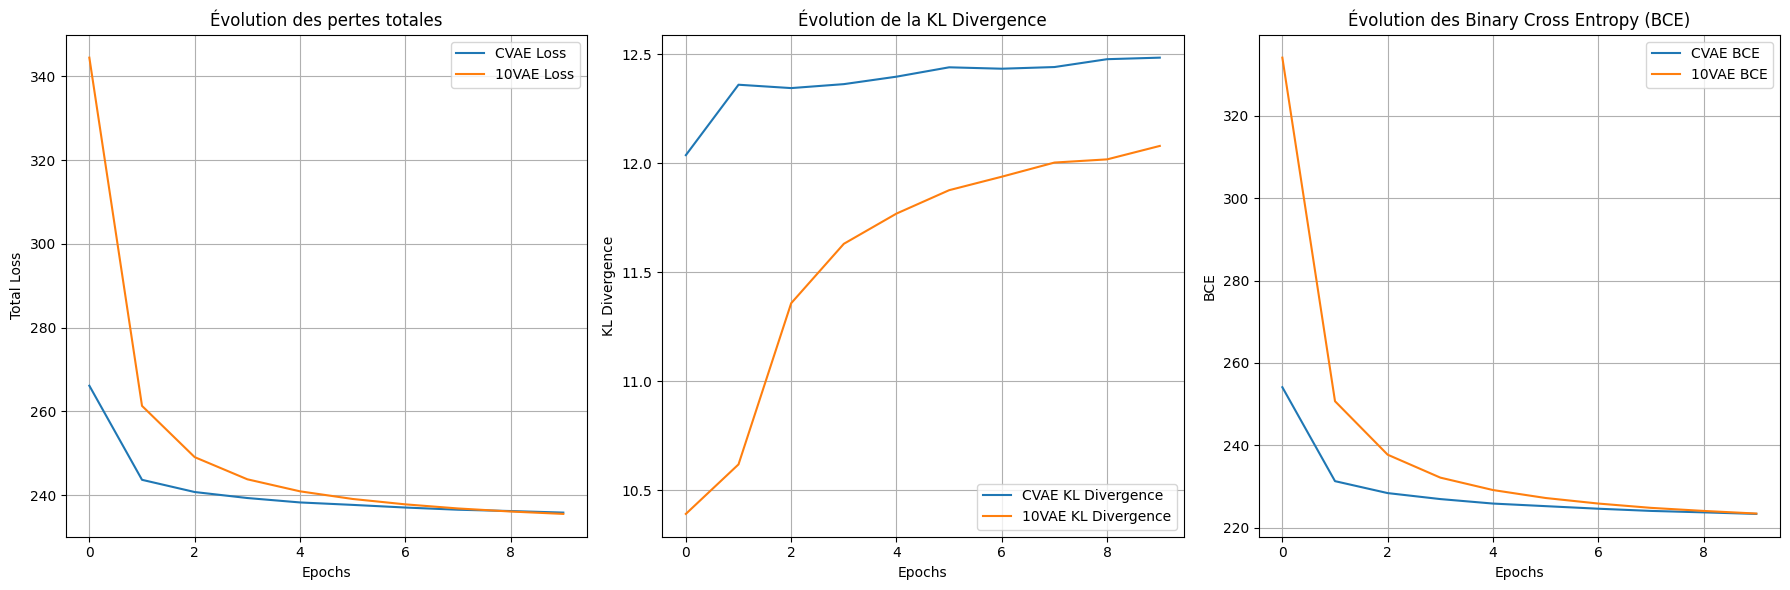

In [51]:
# Affichage de l'évolution des loss

plot_losses(loss_dict['evol_losses'], loss_dict['evol_bce'], loss_dict['evol_kl']) # Losses de validartion ? d'entrainement ?

On remarque ici que l'entrainement est beaucoup plus rapide avec le CVAE qu'avec les VAE. Cela peut s'expliquer par le fait que le l'on donne des données de toutes les classes au CVAE, et donc plus de donénes, avec une structure assez similaire. Le CVAE apprend donc plus rapidement la structure de nos données, et l'entrainement est donc plus rapide.

Néanmoins, la fonction de perte des VAE, au bout de 10 époques, rattrape celle des CVAE : on peut donc supposer qu'avec un plus grand nombre d'époque, les VAE seraient plus performants que le CVAE. Cela est assez logique, car les VAE étant au nombre de 10, ils ont 10 fois plus de poids par rpaport au CVAE.

On observe enfin que la KL-Divergence est plus faible pour les VAE que pour le CVAE : la représentation des données dans l'espace latent est plus proche d'une loi normale centrée réduite. Comme chaque VAE se concentre sur une seule classe, il est plus simple de représenter chaque classe comme une loi proche d'une normale dans l'espace latent, cette observation est donc cohérente. On aurait même pu s'attendre à de plus gros écarts entre nos modèle pour cette perte.

#### Pertes sur la fonction de test

In [ ]:
# Calcul des pertes pour le CVAE

loss_dict_test = evaluate(model_CVAE_dict, test_loader, device, kl_weight=KL_WEIGHT, have_labels=True)

In [ ]:
# Idem pour le VAE

loss_dict_test_vae = {}

for i in range(10):
    name = 'VAE' + str(i)
    loss_dict_test_vae[name] = evaluate(dict_model={name:models_VAE_dict[name]}, test_loader=test_dataloader_class[i], device=device, kl_weight=KL_WEIGHT, have_labels = False)



loss_dict_test_vae_av = {'evol_losses': [], 'evol_bce': [], 'evol_kl': []}

avg_losses = sum(loss_dict_test_vae[f'VAE{k}']['evol_losses'][f'VAE{k}'] for k in range(10)) / 10 # 10 correspond au nombre de classe
avg_bce = sum(loss_dict_test_vae[f'VAE{k}']['evol_bce'][f'VAE{k}'] for k in range(10)) / 10
avg_kl = sum(loss_dict_test_vae[f'VAE{k}']['evol_kl'][f'VAE{k}'] for k in range(10)) / 10


    # Append the averages to the result dictionary

loss_dict_test_vae_av['evol_losses'].append(avg_losses)
loss_dict_test_vae_av['evol_bce'].append(avg_bce)
loss_dict_test_vae_av['evol_kl'].append(avg_kl)


In [59]:
print("Loss sur le jeu de test du CVAE : ", loss_dict_test['evol_losses']['CVAE'])
print("Loss sur le jeu de test des VAE :", loss_dict_test_vae_av['evol_losses'][0])

print("\nLoss BCE sur le jeu de test du CVAE : ", loss_dict_test['evol_bce']['CVAE'])
print("Loss BCE sur le jeu de test des VAE :", loss_dict_test_vae_av['evol_bce'][0])

print("\nLoss KL sur le jeu de test du CVAE : ", loss_dict_test['evol_kl']['CVAE'])
print("Loss KL sur le jeu de test des VAE :", loss_dict_test_vae_av['evol_kl'][0])

Loss sur le jeu de test du CVAE :  238.04568728027343
Loss sur le jeu de test des VAE : 237.78736816406249

Loss BCE sur le jeu de test du CVAE :  225.57076970214843
Loss BCE sur le jeu de test des VAE : 225.9492767578125

Loss KL sur le jeu de test du CVAE :  12.474916445922851
Loss KL sur le jeu de test des VAE : 11.838091113281248


Ici, la valeur des loss obtenue sur le jeu de test est très proche de celle obtenue sur le jeu d'entrainement, pour les deux modèles. Ils ne sont donc pas overfittés, et on pourrait entrainer les modèles plus longtemps pour de meilleures performances.

### Comparaison des images reconstruites

Nous allons maintenant comparer les images générées par le CVAE et par les VAE.

In [31]:
def compare_CVAE_and_VAEs(models_dict, cvae_dict, test_loader, device):
    """
    Compare les reconstructions d'un CVAE et de 10 VAE spécialisés sur des catégories spécifiques.

    Args:
        models_dict (dict): Dictionnaire contenant les 10 modèles VAE (ex: "VAE0", "VAE1", ...)
        cvae_model (nn.Module): Le modèle CVAE
        test_loader (DataLoader): DataLoader pour les images de test
        device (torch.device): Le device CPU ou GPU
    """

    # Récupérer un batch d'images et de labels
    random_images, random_labels = next(iter(test_loader))
    random_images = random_images.to(device)
    random_labels_one_hot = torch.eye(10)[random_labels].to(device)  # Encodage one-hot des labels

    # Initialiser les dictionnaires pour stocker les reconstructions
    dict_recons = {"CVAE Reconstructions": []}
    dict_recons["VAE Reconstructions"] = []

    # Reconstructions par le CVAE
    cvae_model = cvae_dict["CVAE"][0]
    cvae_model.eval()
    with torch.no_grad():
        cvae_recons, _, _ = cvae_model(random_images, random_labels_one_hot)
        cvae_recons = cvae_recons.cpu().numpy().squeeze()  # Convertir en numpy
        dict_recons["CVAE Reconstructions"] = cvae_recons

    # Reconstructions par les VAE spécifiques aux labels
    for i, image in enumerate(random_images):  # Itérer sur chaque image
        label = random_labels[i].item()  # Récupérer le label de l'image
        vae_model = models_dict[f"VAE{label}"][0]  # Sélectionner le bon modèle VAE (ex: VAE2 pour label=2)
        vae_model.eval()

        with torch.no_grad():
            image = image.unsqueeze(0)  # Ajouter une dimension batch
            vae_recons, _, _ = vae_model(image)  # Reconstruction par le VAE
            vae_recons = vae_recons.cpu().numpy().squeeze()  # Convertir en numpy
            dict_recons[f"VAE Reconstructions"].append(vae_recons)

    # Préparer les images originales pour l'affichage
    random_images = random_images.cpu().numpy().squeeze()

    # Afficher les comparaisons
    image_comparison_with_vaes(random_images, random_labels, dict_recons)


def image_comparison_with_vaes(original_images, labels, dict_recons, n_images=6):
    """ Affiche les images originales et leurs reconstructions par le CVAE et les VAE spécialisés.

    Args:
        original_images (numpy.ndarray): Les images originales
        labels (torch.Tensor): Les labels des images
        dict_recons (dict): Dictionnaire des reconstructions par modèle
        n_images (int): Nombre d'images à afficher
    """

    # Limiter à n_images
    original_images = original_images[:n_images]
    labels = labels[:n_images]

    # Créer une figure avec un nombre de lignes pour les reconstructions + 1 pour les images originales
    n_rows = len(dict_recons) + 1
    fig, ax = plt.subplots(n_rows, n_images, figsize=(20, 3 * n_rows))

    # Affichage des images originales
    for i in range(n_images):
        ax[0, i].imshow(original_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, i].set_title(f"Original (Label: {labels[i].item()})")

    # Affichage des reconstructions
    for row, (key, recons) in enumerate(dict_recons.items(), start=1):
        for i in range(n_images):
            if "VAE" in key:  # Pour les modèles VAE, on prend la reconstruction correspondante à la classe
                recons_image = recons[i]
            else:  # Pour le CVAE
                recons_image = recons[i]
            ax[row, i].imshow(recons_image, cmap='gray')
            ax[row, i].axis('off')
        ax[row, 0].set_title(key)

    plt.tight_layout()
    plt.show()

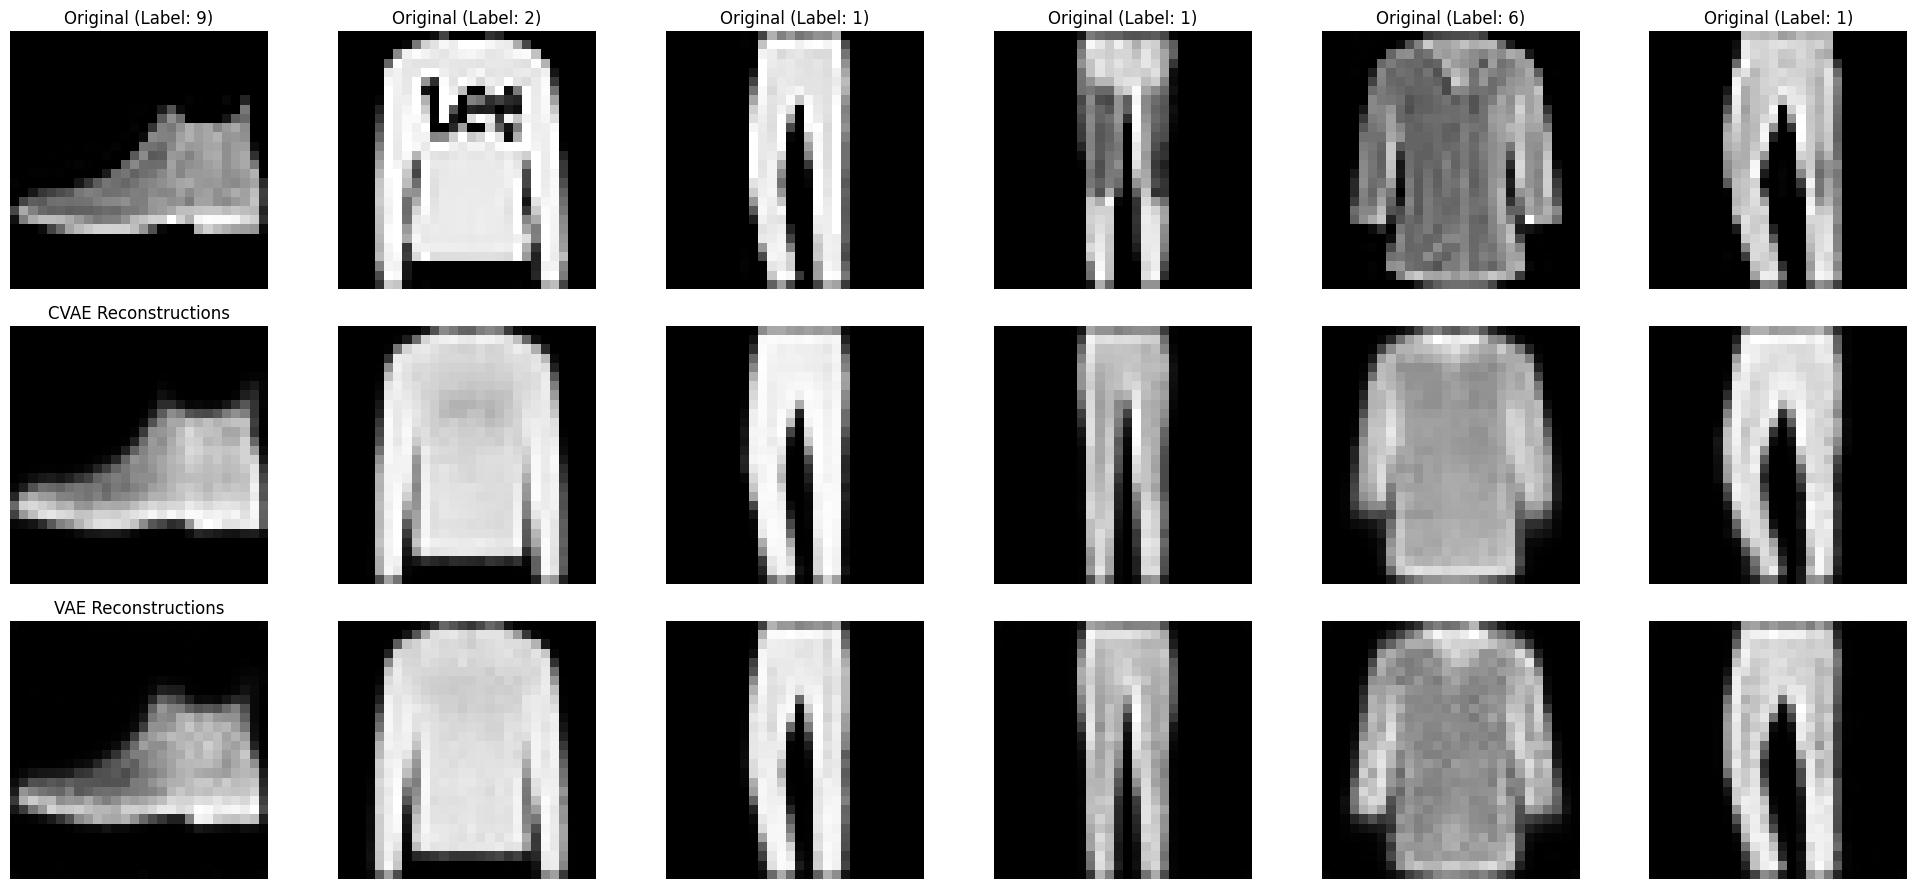

In [32]:
# Meme fonction pour le VAE
compare_CVAE_and_VAEs(models_VAE_dict, model_CVAE_dict, test_loader, device)

En regardant les images ci-dessus, on n'observe pas de différences flagrante entre la reconstruction par les VAE et par les CVAE. Cela est cohérent avec les résultats que nous avons obtenus précédemment, avec des pertes BCE ayant des valeurs similaires pour les deux modèles.

### Génération d'images


In [44]:
def generate_samples_plot_vae(models_dict, cvae_dict, num_samples=10):
    """
    Génère et affiche des échantillons générés par un CVAE et des VAE spécialisés (par classe).

    Args:
        models_dict (dict): Dictionnaire contenant les modèles VAE spécialisés (ex: "VAE0", ..., "VAE9")
        cvae_model (nn.Module): Le modèle CVAE
        num_samples (int): Nombre d'échantillons à générer (doit correspondre au nombre de classes)
        device (str): CPU ou GPU
    """

    # S'assurer que tous les modèles sont en mode évaluation
    cvae_model = cvae_dict["CVAE"][0]
    cvae_model.eval()
    for model_name, (model, _) in models_dict.items():
        model.eval()

    with torch.no_grad():
        # Générer les étiquettes pour le CVAE (0 à num_samples - 1) sous forme one-hot
        y = torch.eye(10).to(device)  # Labels conditionnels pour les 10 classes (pour CVAE)
        
        # Créer un tableau pour les échantillons
        num_rows = 2  # Lignes : 1 CVAE + 1 VAEs
        num_cols = num_samples + 1       # Colonnes : num_samples + 1 pour les noms des modèles
        fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 2 * num_rows))

        # **1. Génération d'échantillons par le CVAE**
        z_cvae = torch.randn(num_samples, cvae_model.latent_dim).to(device)  # Vecteurs latents aléatoires
        cvae_samples = cvae_model.decode(z_cvae, y).cpu().view(num_samples, 1, 28, 28)

        # Afficher le nom du modèle CVAE
        ax[0, 0].text(0.5, 0.5, 'CVAE', horizontalalignment='center',
                      verticalalignment='center', fontsize=12, transform=ax[0, 0].transAxes)
        ax[0, 0].axis('off')

        # Afficher les échantillons générés par le CVAE
        for j in range(1, num_samples + 1):
            ax[0, j].imshow(cvae_samples[j-1].squeeze(0), cmap='gray')
            ax[0, j].axis('off')
            ax[0, j].set_title(f"Label={j-1}")

        # **2. Génération d'échantillons par les VAEs spécifiques**
        # Afficher le nom du VAE
        ax[1, 0].text(0.5, 0.5, "VAE", horizontalalignment='center',
                    verticalalignment='center', fontsize=12, transform=ax[1, 0].transAxes)
        ax[1, 0].axis('off')
        for i in range(10):
            vae_model = models_dict["VAE"+str(i)][0]
            z_vae = torch.randn(1, vae_model.latent_dim).to(device)  # Un vecteur latent par VAE
            vae_samples = vae_model.decode(z_vae).cpu().view(1, 28, 28)  # Reconstruit une image

            ax[1, i+1].imshow(vae_samples.squeeze(0), cmap='gray')
            ax[1, i+1].axis('off')

        plt.tight_layout()
        plt.show()

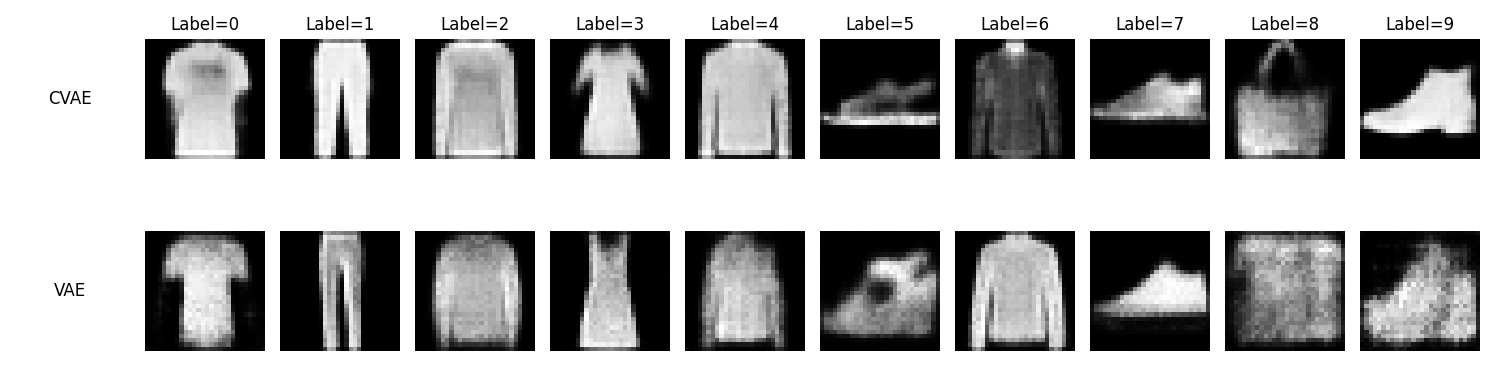

In [42]:
# Call function

generate_samples_plot_vae(models_VAE_dict, model_CVAE_dict) # pb de fonction pour CVAE et VAE ici


Comme précédemment, il est difficle de comparer les images générées par les deux modèles avec aussi peu d'images. Néanmoins, il semblerait que les images générées par le CVAE sont plus réalistes que celle générées par le VAE. On remarque également des difficultés plus importantes pour certaines catégories d'articles, ici les sandales, les sacs et les talons (Labels 5, 8 et 9)

In [60]:
def generate_samples_dict_VAE(model_dict, num_samples=10, category=-1):
    # Set model to evaluation mode
    #model.eval()

    with torch.no_grad():
        # Generate `y` labels (a list from 0 to num_samples-1 to ensure they match classes)
        if category == -1:
            y = generate_random_matrix(num_samples, 10).to(device)
        else:
            # peut-être faire une petite fonction pour cette partie
            y = torch.zeros((num_samples, 10), dtype=torch.int).to(device)
            y[:, category] = 1

        z = torch.randn(num_samples, 10).to(device)  # Random latent vectors
            # Use decode method depending on whether it's a VAE or CVAE

        samples_list = []
        for i in range(num_samples):
            model = model_dict["VAE"+str(int(torch.argmax(y[i])))][0]
            samples_list.append(model.decode(z[i])[0])
 
        samples = torch.stack(samples_list)
        return {"VAE":(samples, y)}


In [61]:
# Definir une fonction pour générer des sample pour chaque modèle du dictionnaire

samples_dict_CVAE = generate_samples_dict(model_CVAE_dict, 10000)
samples_dict_VAE = generate_samples_dict_VAE(models_VAE_dict, 10000)


In [62]:
accuracy_CVAE = eval_classif_dict(samples_dict_CVAE)
accuracy_VAE = eval_classif_dict(samples_dict_VAE)

print(accuracy_CVAE, accuracy_VAE)

{'CVAE': 83.77} {'VAE': 87.0}


On observe ici que le classifieur s'en sort beaucoup mieux sur les données générées par le VAE que par celles générées par le CVAE. Cela signifie que le type d'article est plus reconnaissable avec le VAE. Cela peut s'expliquer car les modèles du VAE sont chacun spécialisés sur un type d'article, et chaque modèle se concentre donc plus sur les spécificité du type d'article qui lui correpsond.

Résultats précédents : {'CVAE': 83.45, 83.77} {'VAE': 89.54, 87}

In [63]:
fid_score_vae = comupte_fid_dict(samples_dict_VAE, test_loader, batch_size=32)
fid_score_cvae = comupte_fid_dict(samples_dict_CVAE, test_loader, batch_size=32)

print(fid_score_cvae)
print(fid_score_vae)

Processing Batches: 100%|██████████| 79/79 [00:20<00:00,  3.89it/s]


{'CVAE': tensor(0.3105, device='cuda:0')}
{'VAE': tensor(0.3821, device='cuda:0')}


On obtient ici de meilleurs résultats pour le FID avec le CVAE qu'avec le VAE. Cela signifie que le CVAE a mieux compris la structure des données que le VAE, et il a donc tendance à générer des meilleurs images.

{'CVAE': tensor(0.3101, 0.3105)}
{'VAE': tensor(0.3652, 0.3821)}

Conclusion de la partie : ....

#### Affichage espace latent un VAE et CVAE

A voir si je le replace

In [ ]:
models_dict = {
    'VAE': config_model(ConvVAE, latente_dim=2,lr = LEARNING_RATE),
    'CVAE': config_model(CVAE, latente_dim=2, lr = LEARNING_RATE)
}

In [ ]:
_ = train(dict_model=models_dict, train_loader=train_loader, device=device, kl_weight=KL_WEIGHT, epochs= EPOCH)

In [ ]:
plot_latent_space(models_dict=models_dict, test_dataset= test_dataset, device =device,  kl_weight=KL_WEIGHT)

## V) Comparaison de la dimension de l'espace latent

In [27]:
models_dict_1atent = {
    '4CVAE': config_model(CVAE, 4, LEARNING_RATE),
    '6CVAE': config_model(CVAE, 6, LEARNING_RATE),
    '10CVAE': config_model(CVAE, 10, LEARNING_RATE),
    '16CVAE': config_model(CVAE, 16, LEARNING_RATE),
    '32CVAE': config_model(CVAE, 32, LEARNING_RATE),
    '64CVAE': config_model(CVAE, 64, LEARNING_RATE),
    '128CVAE': config_model(CVAE, 128, LEARNING_RATE),
}

In [28]:
loss_dict_latent = train(dict_model=models_dict_1atent, train_loader=train_loader, device=device, kl_weight=KL_WEIGHT, epochs=EPOCH)

Epoch 1: Model 4CVAE - Loss: 267.9436, BCE: 260.4030, KLD: 7.5405
Epoch 1: Model 6CVAE - Loss: 265.7732, BCE: 253.3964, KLD: 12.3768
Epoch 1: Model 10CVAE - Loss: 263.4831, BCE: 251.1910, KLD: 12.2922
Epoch 1: Model 16CVAE - Loss: 265.9998, BCE: 252.5501, KLD: 13.4497
Epoch 1: Model 32CVAE - Loss: 268.5129, BCE: 254.5901, KLD: 13.9228
Epoch 1: Model 64CVAE - Loss: 269.5005, BCE: 254.6908, KLD: 14.8097
Epoch 1: Model 128CVAE - Loss: 279.4910, BCE: 264.5028, KLD: 14.9882
Epoch 2: Model 4CVAE - Loss: 247.7068, BCE: 240.0273, KLD: 7.6796
Epoch 2: Model 6CVAE - Loss: 243.8644, BCE: 231.5198, KLD: 12.3446
Epoch 2: Model 10CVAE - Loss: 243.6505, BCE: 231.2568, KLD: 12.3938
Epoch 2: Model 16CVAE - Loss: 244.3405, BCE: 230.9995, KLD: 13.3410
Epoch 2: Model 32CVAE - Loss: 245.3602, BCE: 231.9360, KLD: 13.4241
Epoch 2: Model 64CVAE - Loss: 246.8546, BCE: 233.4050, KLD: 13.4497
Epoch 2: Model 128CVAE - Loss: 249.1073, BCE: 235.6471, KLD: 13.4602
Epoch 3: Model 4CVAE - Loss: 245.0584, BCE: 237.4206

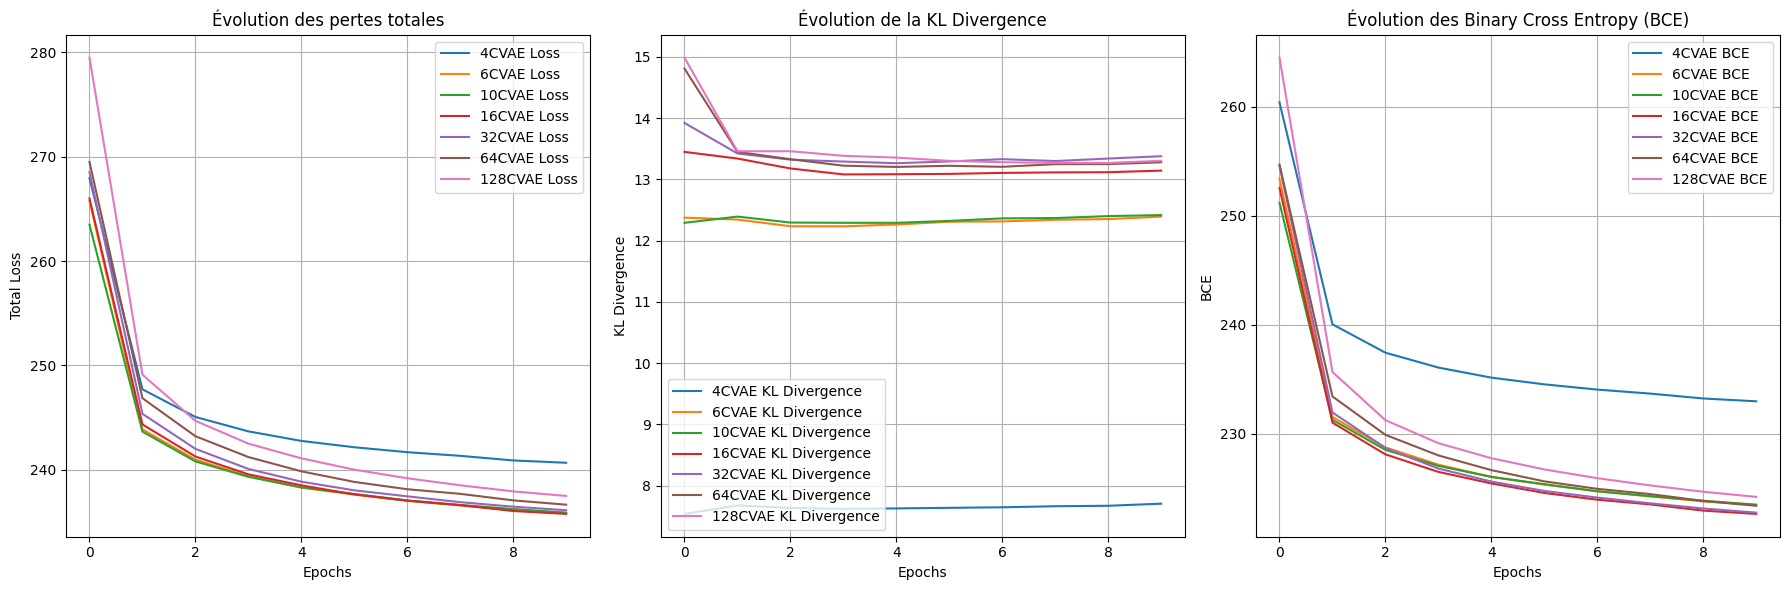

In [30]:
plot_losses(loss_dict_latent['evol_losses'], loss_dict_latent['evol_bce'], loss_dict_latent['evol_kl'])

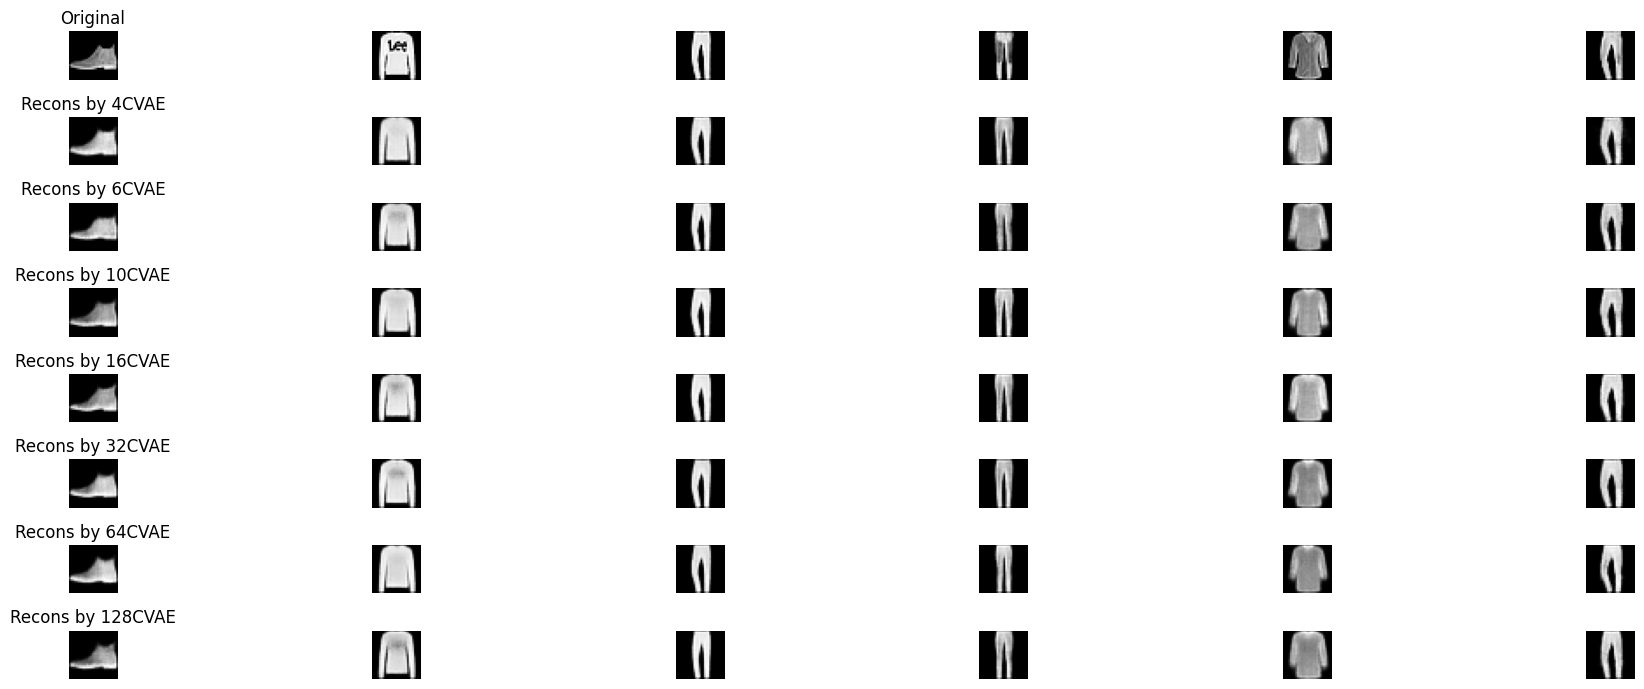

In [31]:
# Comparison of model reconstructions
compare_model_reconstructions(models_dict_1atent, test_loader, device)

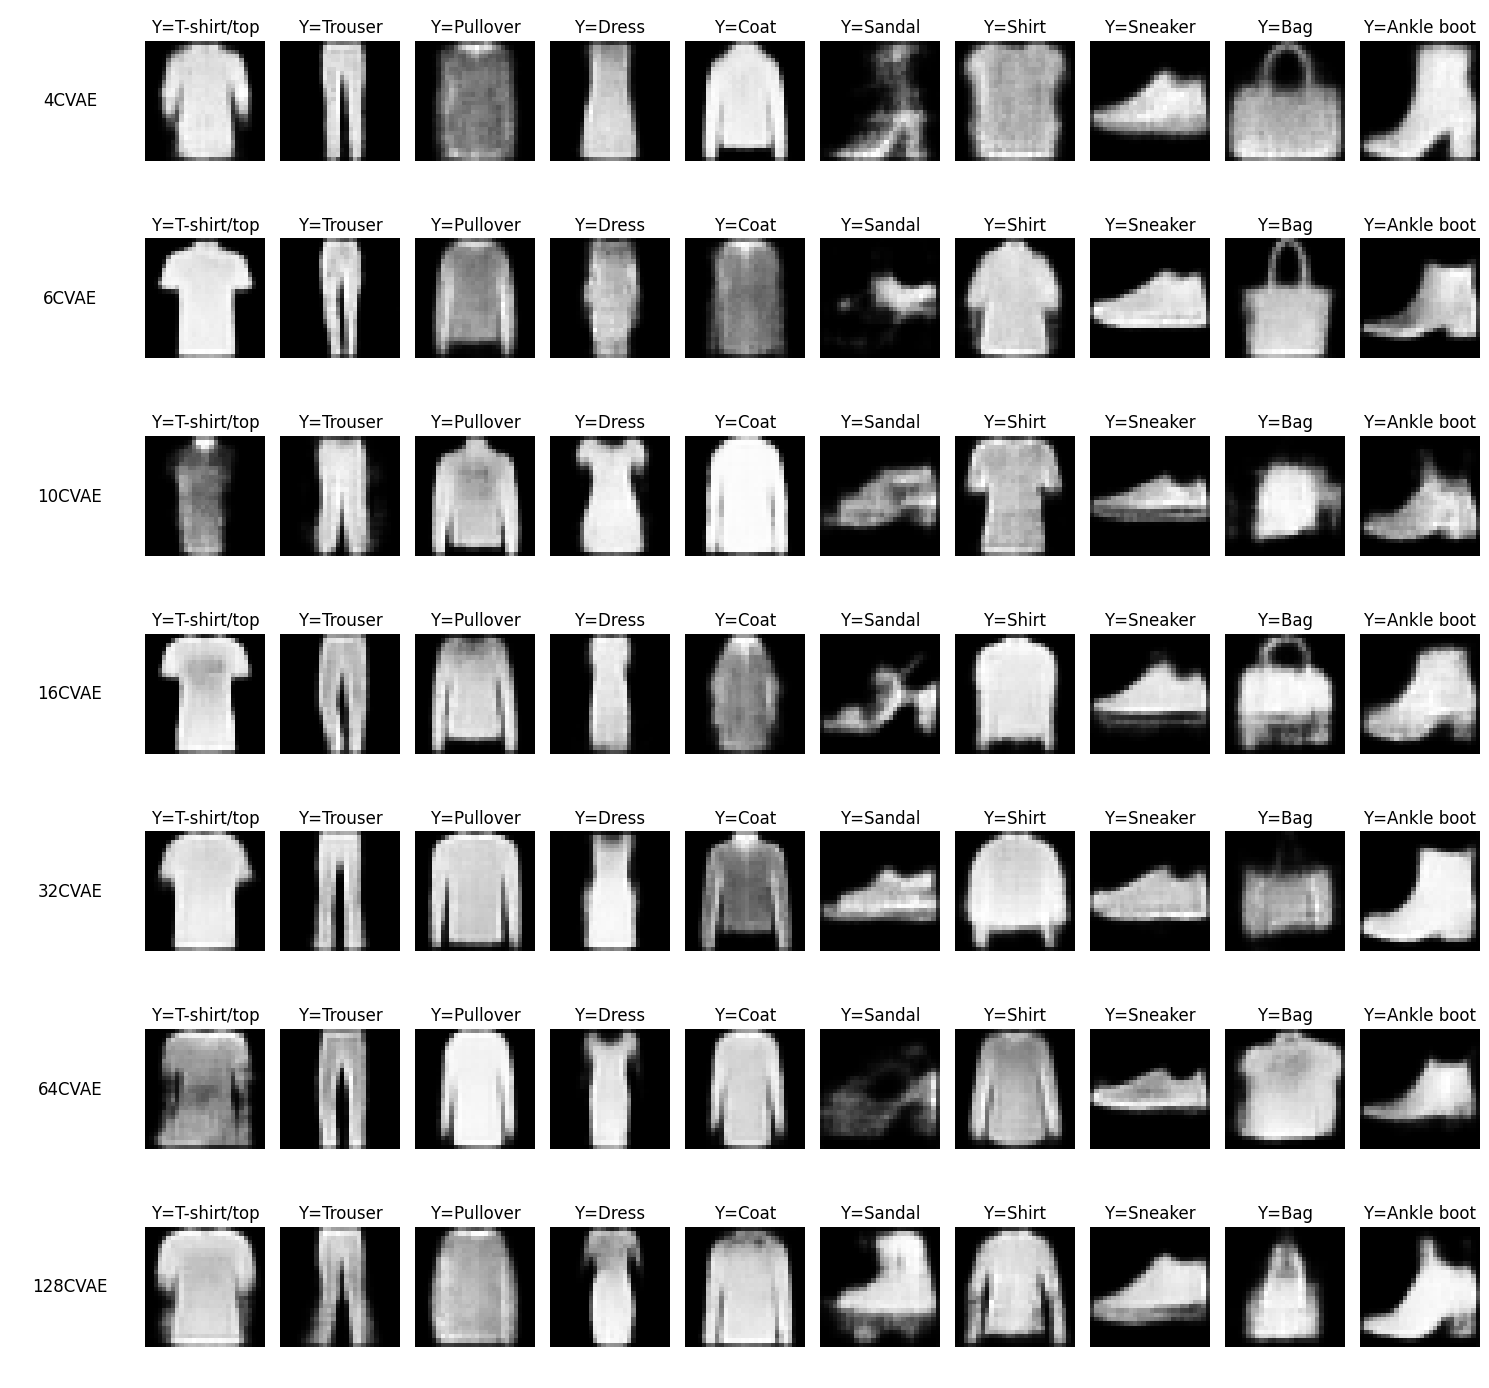

In [32]:
generate_samples_plot(models_dict=models_dict_1atent)

In [40]:
samples_dict_latent = generate_samples_dict(models_dict_1atent, 10000)

In [45]:
accuracy_latent = eval_classif_dict(samples_dict_latent)

print(accuracy_latent)

{'4CVAE': 84.82, '6CVAE': 81.41, '10CVAE': 82.9, '16CVAE': 83.04, '32CVAE': 82.11, '64CVAE': 78.81, '128CVAE': 78.16}


In [66]:
fid_score = comupte_fid_dict(samples_dict_latent, test_loader, batch_size=32)

print(fid_score)

Processing Batches: 100%|██████████| 79/79 [00:20<00:00,  3.90it/s]


tensor([[[[2.7491e-04, 3.6442e-05, 3.3527e-05,  ..., 8.4960e-05,
           9.0125e-05, 6.9725e-04],
          [2.3540e-05, 4.5471e-06, 1.5252e-05,  ..., 2.5304e-05,
           1.4719e-05, 1.6147e-04],
          [2.6339e-05, 4.8005e-06, 1.7087e-05,  ..., 3.1807e-05,
           3.2461e-05, 1.8576e-04],
          ...,
          [1.6828e-04, 3.7906e-05, 2.9417e-05,  ..., 4.2352e-05,
           1.0862e-05, 7.4376e-05],
          [4.3389e-04, 5.0022e-05, 2.7966e-05,  ..., 5.6812e-05,
           1.8565e-05, 9.7037e-05],
          [1.7968e-03, 9.4984e-05, 4.6438e-05,  ..., 1.5913e-04,
           1.1094e-04, 9.2521e-04]]],


        [[[3.5230e-04, 5.5047e-05, 6.1247e-05,  ..., 3.9753e-05,
           3.2650e-05, 3.8354e-04],
          [3.0339e-05, 6.0713e-06, 1.2970e-05,  ..., 4.7263e-06,
           1.3640e-06, 3.6615e-05],
          [4.4171e-05, 7.6268e-06, 3.0597e-05,  ..., 6.6266e-06,
           1.6851e-06, 3.1770e-05],
          ...,
          [4.5828e-06, 9.6661e-07, 1.2197e-05,  ..., 7.81

Processing Batches: 100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


tensor([[[[2.8045e-03, 1.3401e-03, 1.4852e-03,  ..., 4.4986e-04,
           2.5404e-04, 1.0650e-03],
          [4.2199e-04, 3.8827e-04, 1.0137e-03,  ..., 2.4629e-04,
           5.2734e-05, 1.3773e-04],
          [1.5906e-04, 1.9739e-04, 1.5552e-03,  ..., 4.8466e-04,
           1.0246e-04, 2.1806e-04],
          ...,
          [3.2812e-05, 4.8827e-05, 1.6623e-03,  ..., 1.1316e-03,
           9.5019e-06, 7.4943e-06],
          [1.7714e-05, 3.1233e-05, 7.4115e-04,  ..., 1.5561e-04,
           1.6265e-06, 8.3075e-06],
          [1.1838e-04, 4.5171e-05, 3.1875e-04,  ..., 5.9814e-05,
           6.2651e-06, 4.0150e-05]]],


        [[[6.5340e-04, 1.9700e-04, 1.6285e-04,  ..., 1.1621e-03,
           9.5289e-04, 2.4437e-03],
          [2.2254e-04, 9.1874e-05, 9.6979e-05,  ..., 5.6865e-04,
           1.7586e-04, 3.3253e-04],
          [2.1754e-04, 1.2581e-04, 1.5569e-04,  ..., 2.8184e-03,
           6.7900e-04, 7.1851e-04],
          ...,
          [1.9796e-04, 9.9638e-05, 1.0511e-04,  ..., 1.15

Processing Batches: 100%|██████████| 79/79 [00:21<00:00,  3.76it/s]


tensor([[[[3.4747e-04, 1.4854e-04, 1.6452e-04,  ..., 1.1434e-04,
           3.0982e-05, 1.1508e-04],
          [2.3135e-05, 1.7250e-05, 6.9657e-05,  ..., 6.2121e-05,
           6.6271e-06, 1.2199e-05],
          [1.6280e-05, 1.3710e-05, 1.4390e-04,  ..., 1.0647e-04,
           5.8788e-06, 2.2860e-05],
          ...,
          [2.8837e-05, 7.6883e-06, 8.0290e-06,  ..., 9.5451e-05,
           6.1461e-06, 5.4323e-06],
          [3.4449e-05, 8.3190e-06, 8.2075e-06,  ..., 2.8987e-05,
           2.0691e-06, 4.9264e-06],
          [3.2650e-04, 6.4633e-05, 4.0640e-05,  ..., 3.7124e-05,
           4.8439e-06, 5.3436e-05]]],


        [[[2.2017e-05, 6.0737e-06, 1.4596e-05,  ..., 1.1556e-05,
           8.4950e-06, 4.3702e-05],
          [1.6454e-06, 9.0497e-07, 9.6793e-06,  ..., 2.2359e-06,
           5.4064e-07, 2.6299e-06],
          [1.0153e-06, 1.3510e-06, 2.5039e-05,  ..., 1.1362e-06,
           3.3652e-07, 1.4778e-06],
          ...,
          [3.0942e-07, 1.5871e-07, 5.2894e-07,  ..., 4.51

Processing Batches: 100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


tensor([[[[2.1871e-03, 3.4585e-04, 5.3153e-04,  ..., 9.8470e-04,
           5.5138e-04, 1.7297e-03],
          [3.2038e-04, 7.1989e-05, 3.1029e-04,  ..., 7.3099e-04,
           2.8620e-04, 9.5278e-04],
          [1.1402e-04, 2.8661e-05, 2.6803e-04,  ..., 1.0634e-03,
           3.0199e-04, 9.8754e-04],
          ...,
          [1.0487e-03, 1.1929e-03, 2.1862e-02,  ..., 3.9012e-01,
           9.0314e-02, 1.1750e-02],
          [1.1207e-03, 8.9658e-04, 1.4821e-02,  ..., 3.1806e-01,
           5.9936e-02, 6.6624e-03],
          [3.0745e-03, 9.1451e-04, 8.3954e-03,  ..., 9.7025e-02,
           1.4301e-02, 7.8731e-03]]],


        [[[1.7490e-04, 3.7150e-06, 3.2919e-06,  ..., 1.1465e-03,
           1.7116e-03, 3.1151e-03],
          [1.5852e-05, 5.1901e-07, 8.2473e-07,  ..., 4.9431e-04,
           5.4686e-04, 5.1343e-04],
          [9.8236e-06, 3.8695e-07, 4.7330e-07,  ..., 6.5392e-04,
           6.0501e-04, 5.3833e-04],
          ...,
          [4.6690e-03, 7.7448e-03, 1.3122e-02,  ..., 2.22

Processing Batches: 100%|██████████| 79/79 [00:21<00:00,  3.74it/s]


tensor([[[[1.2218e-04, 2.5323e-05, 1.5033e-05,  ..., 8.7847e-06,
           7.4405e-06, 1.1130e-04],
          [8.9451e-06, 9.7177e-07, 5.6358e-07,  ..., 8.4373e-07,
           6.0057e-07, 1.3881e-05],
          [3.1041e-06, 5.6003e-07, 3.2857e-07,  ..., 1.1299e-06,
           7.9071e-07, 9.3172e-06],
          ...,
          [2.4991e-07, 9.4856e-09, 7.0752e-08,  ..., 6.6064e-06,
           5.1777e-08, 4.6077e-07],
          [1.2417e-06, 5.3357e-08, 9.3647e-08,  ..., 1.6537e-05,
           3.9924e-07, 1.7695e-06],
          [4.4929e-05, 1.1468e-06, 5.1714e-07,  ..., 7.5079e-05,
           3.9951e-06, 6.3442e-05]]],


        [[[4.6840e-05, 7.9481e-06, 3.7826e-06,  ..., 1.0419e-04,
           5.6452e-05, 4.8459e-04],
          [3.4472e-06, 1.3711e-06, 6.2103e-07,  ..., 1.2521e-05,
           9.6961e-06, 5.9902e-05],
          [3.4968e-06, 1.3492e-06, 1.9674e-06,  ..., 1.9028e-05,
           8.7077e-06, 4.3406e-05],
          ...,
          [2.1693e-04, 6.9502e-05, 7.3512e-05,  ..., 5.93

Processing Batches: 100%|██████████| 79/79 [00:21<00:00,  3.72it/s]


tensor([[[[1.4214e-03, 1.7856e-04, 1.9553e-04,  ..., 8.9412e-05,
           7.5853e-05, 3.0352e-04],
          [3.2493e-04, 4.2494e-05, 3.8574e-05,  ..., 1.3949e-05,
           6.8851e-06, 2.3709e-05],
          [1.7335e-04, 5.1229e-05, 3.5349e-05,  ..., 1.2852e-05,
           2.8514e-06, 2.6472e-05],
          ...,
          [2.1015e-07, 1.9303e-08, 5.2164e-08,  ..., 1.6499e-08,
           1.3879e-07, 1.2667e-06],
          [2.7999e-07, 2.4896e-08, 2.4065e-08,  ..., 1.5509e-09,
           4.5000e-08, 3.4368e-06],
          [2.4159e-05, 1.2362e-06, 2.7016e-07,  ..., 3.2127e-08,
           2.2237e-07, 3.1818e-05]]],


        [[[2.6487e-04, 4.0027e-05, 2.2374e-05,  ..., 8.4214e-05,
           1.1212e-04, 9.6527e-04],
          [2.4751e-05, 7.8587e-06, 4.1634e-06,  ..., 2.4994e-05,
           3.3385e-05, 1.5578e-04],
          [2.3049e-05, 9.7845e-06, 4.2859e-06,  ..., 5.1415e-05,
           4.8017e-05, 1.6761e-04],
          ...,
          [1.2533e-04, 1.5754e-05, 6.7050e-06,  ..., 2.60

Processing Batches: 100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


tensor([[[[6.1469e-04, 1.3982e-04, 9.1864e-05,  ..., 4.6776e-05,
           4.9908e-05, 5.8060e-04],
          [8.5770e-05, 2.4129e-05, 2.9227e-05,  ..., 5.7104e-06,
           5.8795e-06, 3.5521e-05],
          [1.0592e-04, 4.3466e-05, 4.4647e-05,  ..., 1.9929e-05,
           1.1998e-05, 1.4369e-04],
          ...,
          [3.0694e-04, 5.4776e-05, 6.2950e-06,  ..., 2.0072e-05,
           2.3090e-05, 1.0627e-04],
          [2.3759e-04, 5.9603e-05, 4.6408e-06,  ..., 3.6929e-05,
           4.2672e-05, 2.2702e-04],
          [1.8466e-03, 1.8596e-04, 2.3808e-05,  ..., 4.2988e-04,
           1.9579e-04, 9.8152e-04]]],


        [[[6.9320e-04, 1.9932e-04, 5.4769e-05,  ..., 1.2238e-04,
           8.4951e-05, 1.2831e-03],
          [3.7229e-05, 3.8030e-05, 2.7142e-05,  ..., 1.1292e-05,
           8.7805e-06, 1.0232e-04],
          [1.2291e-05, 1.6920e-05, 1.0119e-05,  ..., 7.2014e-06,
           4.3696e-06, 1.0963e-04],
          ...,
          [5.2356e-07, 4.1137e-07, 5.9107e-06,  ..., 1.95

## VI) Comparaison d'architecture de modèles

In [172]:
class CVAE2(nn.Module):
    def __init__(self, latent_dim=10):
        super(CVAE2, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(11, 128, kernel_size=5, stride=2, padding=2),  # 11 channels: 1 for image + 10 for one-hot labels # Output: (128, 13, 13)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 4, 4)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 2, 2)
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(64 * 2 * 2, latent_dim) # size : prod(output) , latent_dim
        self.fc_logvar = nn.Linear(64 * 2 * 2, latent_dim) # size : prod(output) , latent_dim
        self.fc_decode = nn.Linear(latent_dim + 10, 64 * 2 * 2) # size : latent_dim + numclass, prod(output)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding = 1),  # Output: (64, 4, 4)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2, padding=1, output_padding = 1),  # Output: (128, 13, 13)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 1, kernel_size=5, stride=2, padding=2, output_padding = 1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )

    def encode(self, x, y):
        # Concaténer x (image) et y (vecteur one-hot des classes)
        y = y.view(-1, 10, 1, 1)  # Convertir y en (batch_size, num_classes, 1, 1)
        y = y.expand(-1, -1, 28, 28)  # Agrandir y à (batch_size, num_classes, 28, 28)
        x = torch.cat([x, y], dim=1)  # Concaténation sur le canal (dim=1)

        # Passer par l'encodeur convolutionnel
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Aplatir avant la couche fully connected
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        # Concaténer z (vecteur latent) avec y (one-hot)
        z = torch.cat((z, y), dim=1)  # Assurez-vous que y a les dimensions correctes
        z = z.view(z.size(0), -1)  # Verifier z aplati
        z = self.fc_decode(z)  # Transformation par la fully connected
        z = z.view(-1, 64, 2, 2)  # Recréer les dimensions pour passer au décodeur

        # Appliquer le décodeur convolutionnel
        x = self.decoder(z)
        return x


    def forward(self, x, y):
        # Encode
        mu, logvar = self.encode(x, y)
        # Sample latent vector z
        z = self.sample(mu, logvar)
        # Decode
        return self.decode(z, y), mu, logvar

In [165]:
class CVAE3(nn.Module):
    def __init__(self, latent_dim=10):
        super(CVAE3, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(11, 32, kernel_size=4, stride=2, padding=2),  
            nn.Conv2d(32, 32, kernel_size=4, stride=1, padding=1), # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=2),  
            nn.Conv2d(64, 64, kernel_size=4, stride=1, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_decode = nn.Linear(latent_dim+10, 128 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=1, padding=1),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=2),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=1, padding=1),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=2),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )

    def encode(self, x, y):
        # Concaténer x (image) et y (vecteur one-hot des classes)
        y = y.view(-1, 10, 1, 1)  # Convertir y en (batch_size, num_classes, 1, 1)
        y = y.expand(-1, -1, 28, 28)  # Agrandir y à (batch_size, num_classes, 28, 28)
        x = torch.cat([x, y], dim=1)  # Concaténation sur le canal (dim=1)

        '''
        for i, layer in enumerate(self.encoder):
            x = layer(x)
            print(f"Encodeur - Après la couche {i}: {x.shape}")'''

        # Passer par l'encodeur convolutionnel
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Aplatir avant la couche fully connected
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        # Concaténer z (vecteur latent) avec y (one-hot)
        z = torch.cat((z, y), dim=1)  # Assurez-vous que y a les dimensions correctes
        z = z.view(z.size(0), -1)  # Verifier z aplati
        z = self.fc_decode(z)  # Transformation par la fully connected

        z = z.view(-1, 128, 4, 4)  # Recréer les dimensions pour passer au décodeur

        '''
        print(z.shape)
        for i, layer in enumerate(self.decoder):
            z = layer(z)
            print(f"Decoder - Après la couche {i}: {z.shape}")
        '''
        # Appliquer le décodeur convolutionnel
        x = self.decoder(z)
        return x


    def forward(self, x, y):
        # Encode
        mu, logvar = self.encode(x, y)
        # Sample latent vector z
        z = self.sample(mu, logvar)
        # Decode
        return self.decode(z, y), mu, logvar

In [222]:
class CVAE4(nn.Module):
    def __init__(self, latent_dim=10):
        super(CVAE4, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            # Inspired from VGG
            nn.Conv2d(11, 32, kernel_size=3, stride=1, padding=1),  #Output: (32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  #Output: (32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #Output: (32, 14, 14)

            # Bloc 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  #Output: (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  #Output: (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Réduit HxW de moitié  #Output: (64, 7, 7)

            # Bloc 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  #Output: (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),   #Output: (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(128 * 7 * 7, latent_dim)
        self.fc_decode = nn.Linear(latent_dim+10, 128 * 7 * 7)

        # Decoder
        self.decoder = nn.Sequential(
            # Bloc 3 (inverse)
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Bloc 2 (inverse)
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # Bloc 1 (inverse)
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Activation finale pour une sortie entre [0, 1]
        )


    def encode(self, x, y):
        # Concaténer x (image) et y (vecteur one-hot des classes)
        y = y.view(-1, 10, 1, 1)  # Convertir y en (batch_size, num_classes, 1, 1)
        y = y.expand(-1, -1, 28, 28)  # Agrandir y à (batch_size, num_classes, 28, 28)
        x = torch.cat([x, y], dim=1)  # Concaténation sur le canal (dim=1)

        '''
        for i, layer in enumerate(self.encoder):
            x = layer(x)
            print(f"Encodeur - Après la couche {i}: {x.shape}")'''

        # Passer par l'encodeur convolutionnel
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Aplatir avant la couche fully connected
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        # Concaténer z (vecteur latent) avec y (one-hot)
        z = torch.cat((z, y), dim=1)  # Assurez-vous que y a les dimensions correctes
        z = z.view(z.size(0), -1)  # Verifier z aplati
        z = self.fc_decode(z)  # Transformation par la fully connected

        z = z.view(-1, 128, 7, 7)  # Recréer les dimensions pour passer au décodeur

        '''
        print(z.shape)
        for i, layer in enumerate(self.decoder):
            z = layer(z)
            print(f"Decoder - Après la couche {i}: {z.shape}")'''
        

        # Appliquer le décodeur convolutionnel
        x = self.decoder(z)
        return x


    def forward(self, x, y):
        # Encode
        mu, logvar = self.encode(x, y)
        # Sample latent vector z
        z = self.sample(mu, logvar)
        # Decode
        return self.decode(z, y), mu, logvar

In [219]:
class CVAE5(nn.Module):
    def __init__(self, latent_dim=10):
        super(CVAE5, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            # Inspired from VGG
            nn.Conv2d(11, 64, kernel_size=3, stride=1, padding=1),  #Output: (64, 28, 28)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  #Output: (64, 28, 28)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  #Output: (64, 28, 28)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #Output: (64, 14, 14)

            # Bloc 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  #Output: (128, 14, 14)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  #Output: (128, 14, 14)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  #Output: (128, 14, 14)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Réduit HxW de moitié  #Output: (128, 7, 7)
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(128 * 7 * 7, latent_dim)
        self.fc_decode = nn.Linear(latent_dim+10, 128 * 7 * 7)

        # Decoder
        self.decoder = nn.Sequential(
            # Bloc 2 (inverse)
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Bloc 1 (inverse)
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Activation finale pour une sortie entre [0, 1]
        )


    def encode(self, x, y):
        # Concaténer x (image) et y (vecteur one-hot des classes)
        y = y.view(-1, 10, 1, 1)  # Convertir y en (batch_size, num_classes, 1, 1)
        y = y.expand(-1, -1, 28, 28)  # Agrandir y à (batch_size, num_classes, 28, 28)
        x = torch.cat([x, y], dim=1)  # Concaténation sur le canal (dim=1)

        '''
        for i, layer in enumerate(self.encoder):
            x = layer(x)
            print(f"Encodeur - Après la couche {i}: {x.shape}")'''

        # Passer par l'encodeur convolutionnel
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Aplatir avant la couche fully connected
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        # Concaténer z (vecteur latent) avec y (one-hot)
        z = torch.cat((z, y), dim=1)  # Assurez-vous que y a les dimensions correctes
        z = z.view(z.size(0), -1)  # Verifier z aplati
        z = self.fc_decode(z)  # Transformation par la fully connected

        z = z.view(-1, 128, 7, 7)  # Recréer les dimensions pour passer au décodeur

        '''
        print(z.shape)
        for i, layer in enumerate(self.decoder):
            z = layer(z)
            print(f"Decoder - Après la couche {i}: {z.shape}")'''
        

        # Appliquer le décodeur convolutionnel
        x = self.decoder(z)
        return x


    def forward(self, x, y):
        # Encode
        mu, logvar = self.encode(x, y)
        # Sample latent vector z
        z = self.sample(mu, logvar)
        # Decode
        return self.decode(z, y), mu, logvar

In [223]:
models_dict = {
    'CVAE1': config_model(CVAE, LATENT_DIM, LEARNING_RATE),
    'CVAE2': config_model(CVAE2, LATENT_DIM, LEARNING_RATE),
    'CVAE3': config_model(CVAE3, LATENT_DIM, LEARNING_RATE),
    'CVAE4': config_model(CVAE4, LATENT_DIM, LEARNING_RATE),
    'CVAE5': config_model(CVAE5, LATENT_DIM, LEARNING_RATE),
}

In [225]:
loss_dict = train(dict_model=models_dict, train_loader=train_loader, device=device, kl_weight=KL_WEIGHT, epochs=EPOCH)

Epoch 1: Model CVAE1 - Loss: 262.9788, BCE: 249.6745, KLD: 13.3043
Epoch 1: Model CVAE2 - Loss: 265.1620, BCE: 253.3149, KLD: 11.8471
Epoch 1: Model CVAE3 - Loss: 272.6416, BCE: 261.5350, KLD: 11.1066
Epoch 1: Model CVAE4 - Loss: 262.0808, BCE: 251.4110, KLD: 10.6698
Epoch 1: Model CVAE5 - Loss: 264.4715, BCE: 253.0875, KLD: 11.3840
Epoch 2: Model CVAE1 - Loss: 244.1558, BCE: 231.4163, KLD: 12.7395
Epoch 2: Model CVAE2 - Loss: 245.2420, BCE: 233.5044, KLD: 11.7376
Epoch 2: Model CVAE3 - Loss: 246.5529, BCE: 236.0846, KLD: 10.4683
Epoch 2: Model CVAE4 - Loss: 242.8852, BCE: 232.0554, KLD: 10.8297
Epoch 2: Model CVAE5 - Loss: 244.9487, BCE: 234.0245, KLD: 10.9242
Epoch 3: Model CVAE1 - Loss: 241.2017, BCE: 228.6185, KLD: 12.5833
Epoch 3: Model CVAE2 - Loss: 241.8740, BCE: 230.3111, KLD: 11.5628
Epoch 3: Model CVAE3 - Loss: 242.8436, BCE: 232.4719, KLD: 10.3717
Epoch 3: Model CVAE4 - Loss: 239.7300, BCE: 228.6771, KLD: 11.0529
Epoch 3: Model CVAE5 - Loss: 241.5975, BCE: 230.5556, KLD: 11.

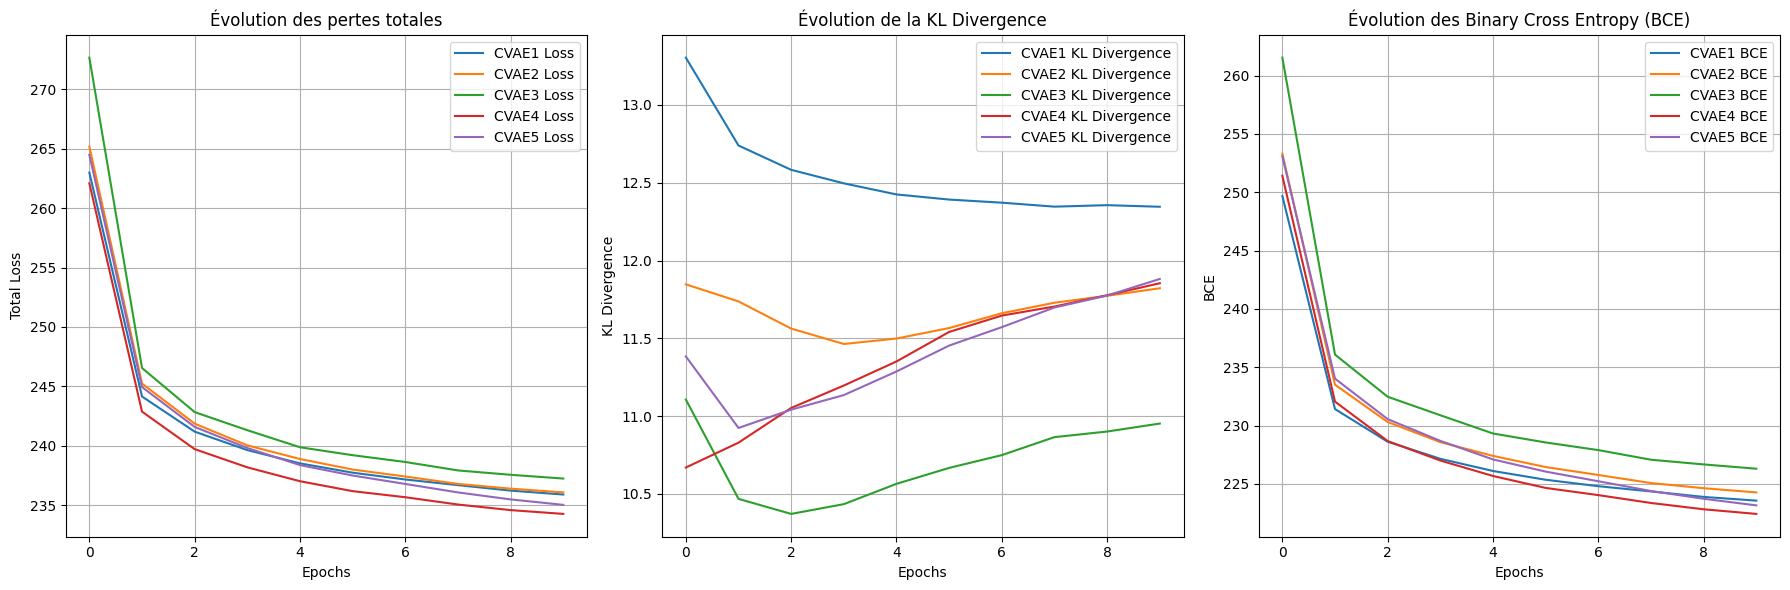

In [226]:
plot_losses(loss_dict['evol_losses'], loss_dict['evol_bce'], loss_dict['evol_kl'])

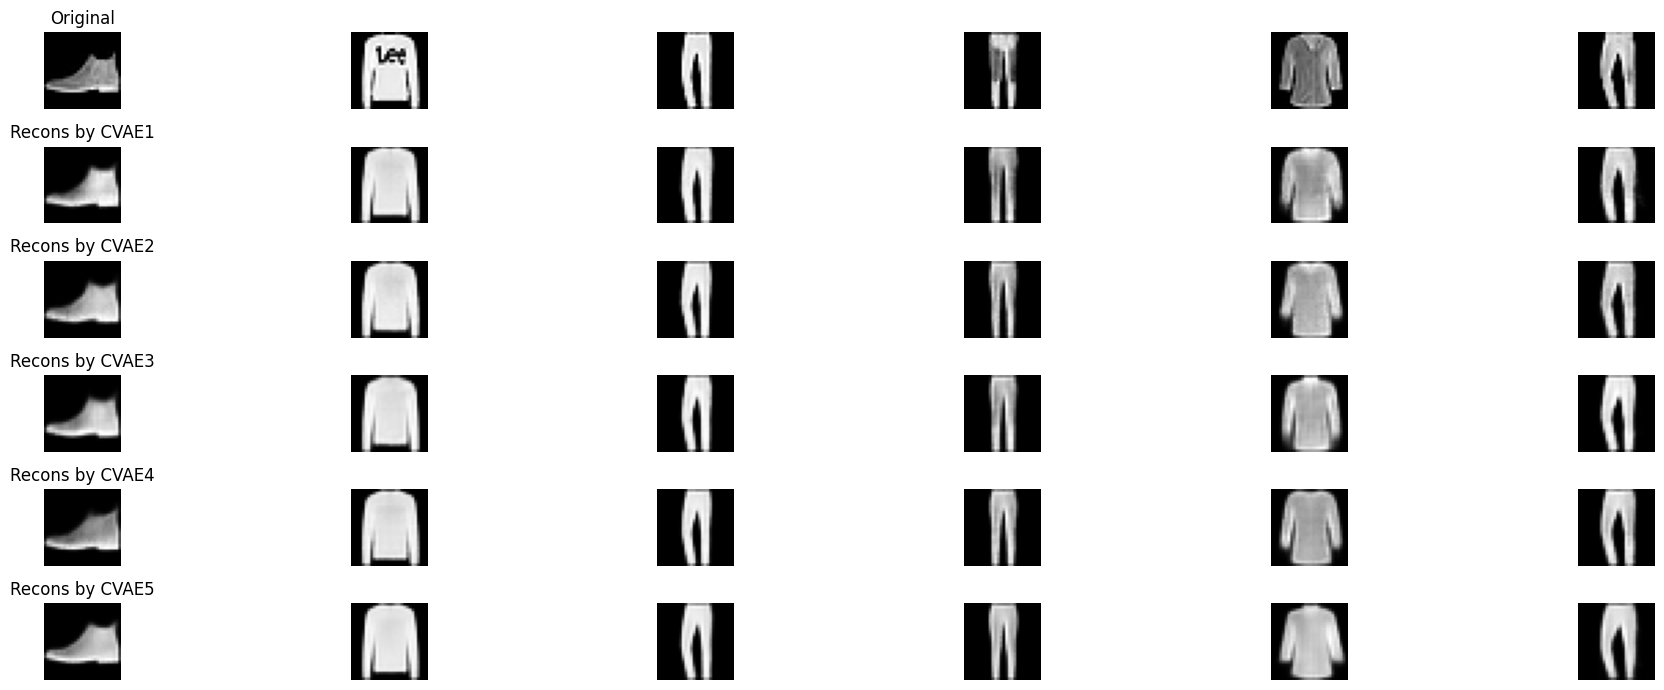

In [234]:
compare_model_reconstructions(models_dict, test_loader, device)

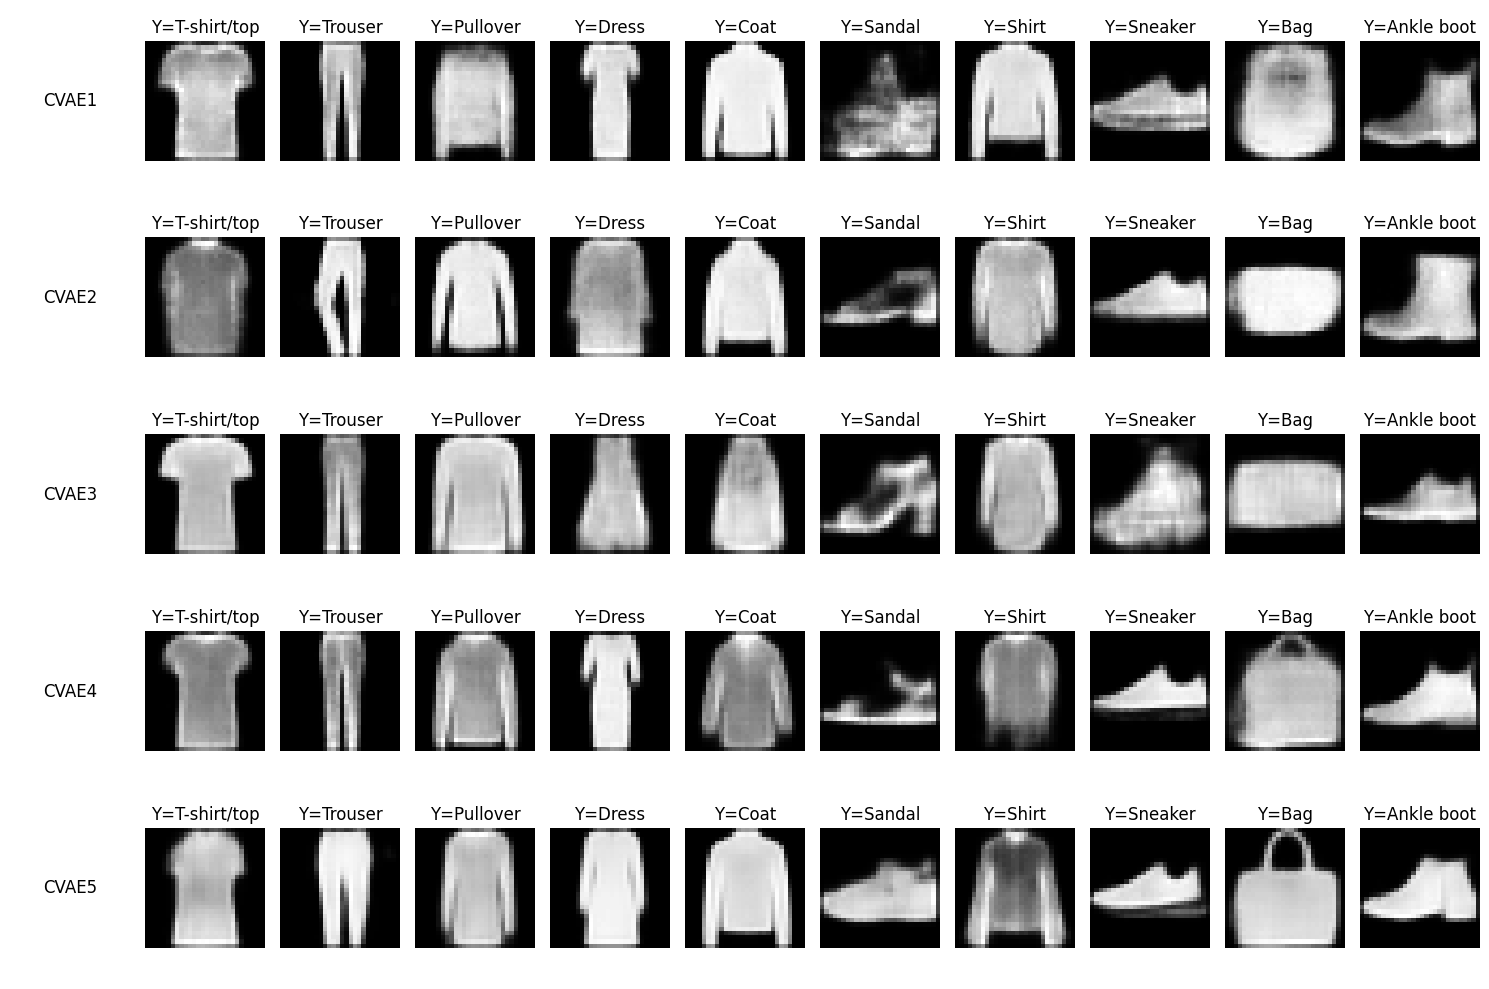

In [235]:
generate_samples_plot(models_dict=models_dict)

In [239]:
samples_dict = generate_samples_dict(models_dict, 10000)

In [240]:
accuracy_latent = eval_classif_dict(samples_dict)

print(accuracy_latent)

{'CVAE1': 79.51, 'CVAE2': 80.72, 'CVAE3': 78.61, 'CVAE4': 80.54, 'CVAE5': 80.22}


In [241]:
fid_score = comupte_fid_dict(samples_dict_latent, test_loader, batch_size=32)

print(fid_score)

Processing Batches: 100%|██████████| 79/79 [00:20<00:00,  3.84it/s]


tensor([[[[1.6420e-04, 2.0791e-05, 2.6211e-05,  ..., 1.1854e-05,
           2.1844e-05, 2.8267e-04],
          [3.0971e-06, 5.9751e-07, 2.3301e-06,  ..., 1.6057e-06,
           5.1877e-06, 3.0106e-05],
          [7.6947e-07, 2.2140e-07, 1.0354e-06,  ..., 6.9173e-06,
           1.8150e-05, 3.2139e-05],
          ...,
          [2.3656e-07, 2.3412e-07, 1.0208e-05,  ..., 2.3543e-03,
           2.4387e-05, 6.2549e-06],
          [9.3978e-07, 7.0375e-07, 1.5357e-05,  ..., 2.2801e-03,
           4.2236e-05, 1.3698e-05],
          [4.2462e-05, 3.1192e-06, 6.2636e-05,  ..., 1.2577e-03,
           8.4259e-05, 1.2018e-04]]],


        [[[2.1047e-05, 2.6873e-06, 2.5725e-06,  ..., 7.5941e-05,
           2.3997e-05, 8.6863e-05],
          [1.6081e-07, 6.3102e-08, 4.6024e-07,  ..., 3.0592e-05,
           4.6512e-06, 6.5474e-06],
          [1.2499e-08, 8.8306e-09, 1.9766e-07,  ..., 1.9962e-05,
           1.6902e-06, 5.4096e-06],
          ...,
          [2.5565e-06, 5.5702e-06, 2.6969e-04,  ..., 8.65

Processing Batches: 100%|██████████| 79/79 [00:21<00:00,  3.67it/s]


tensor([[[[3.0083e-03, 9.2382e-04, 5.5308e-05,  ..., 1.8170e-04,
           1.9977e-04, 4.1102e-04],
          [1.3980e-03, 2.4184e-04, 2.1980e-05,  ..., 8.4044e-05,
           2.6349e-05, 6.0024e-05],
          [9.8143e-04, 2.0902e-04, 2.4986e-05,  ..., 2.6279e-04,
           1.4446e-04, 1.1607e-04],
          ...,
          [6.4954e-04, 1.9095e-04, 7.0914e-05,  ..., 5.9634e-04,
           2.5020e-04, 3.4645e-04],
          [1.5570e-03, 5.0380e-04, 1.8673e-04,  ..., 5.2275e-04,
           4.5995e-04, 4.9008e-04],
          [2.6838e-03, 6.5197e-04, 2.5118e-04,  ..., 7.0257e-04,
           6.7870e-04, 9.2478e-04]]],


        [[[1.5865e-04, 7.0322e-05, 1.7432e-05,  ..., 3.4994e-04,
           4.9992e-04, 7.3753e-04],
          [5.7134e-05, 2.3714e-05, 9.0400e-06,  ..., 2.6747e-04,
           1.4309e-04, 2.4440e-04],
          [7.7166e-05, 3.2599e-05, 1.2954e-05,  ..., 9.9265e-04,
           6.5328e-04, 5.2361e-04],
          ...,
          [1.5662e-05, 3.9144e-06, 1.9897e-06,  ..., 1.66

Processing Batches: 100%|██████████| 79/79 [00:21<00:00,  3.69it/s]


tensor([[[[3.6281e-04, 9.5488e-05, 4.3696e-05,  ..., 4.3777e-06,
           1.6037e-05, 1.0233e-04],
          [3.8121e-05, 9.3051e-06, 5.6960e-06,  ..., 8.2239e-07,
           2.6452e-06, 1.8868e-05],
          [1.4511e-05, 2.7112e-06, 8.6276e-07,  ..., 2.8755e-07,
           7.0454e-07, 7.2785e-06],
          ...,
          [1.2041e-06, 6.9877e-08, 9.3296e-09,  ..., 1.3498e-06,
           5.4809e-06, 1.0120e-05],
          [2.0582e-06, 9.7470e-08, 1.2676e-08,  ..., 9.8068e-07,
           5.7745e-06, 1.6523e-05],
          [1.9198e-05, 2.5367e-06, 2.7119e-07,  ..., 5.8332e-06,
           4.2584e-05, 1.2802e-04]]],


        [[[1.1409e-03, 6.9781e-04, 5.9877e-04,  ..., 4.5901e-04,
           4.3758e-04, 8.4456e-04],
          [4.3408e-04, 4.2649e-04, 5.5063e-04,  ..., 1.1076e-04,
           9.8767e-05, 2.6400e-04],
          [5.9364e-04, 9.3079e-04, 1.0809e-03,  ..., 1.7358e-04,
           1.4716e-04, 2.8961e-04],
          ...,
          [1.5778e-05, 2.5554e-06, 4.8961e-06,  ..., 1.74

Processing Batches: 100%|██████████| 79/79 [00:21<00:00,  3.74it/s]


tensor([[[[5.1222e-05, 3.3693e-05, 5.3801e-05,  ..., 1.4980e-04,
           8.3435e-05, 1.9583e-04],
          [9.8936e-06, 7.5798e-06, 3.7237e-05,  ..., 4.6734e-05,
           1.9836e-05, 1.2789e-05],
          [1.4513e-05, 1.0894e-05, 4.3024e-05,  ..., 6.5715e-05,
           1.6305e-05, 1.8061e-05],
          ...,
          [3.6256e-05, 3.6543e-05, 9.1549e-05,  ..., 5.5565e-05,
           2.6888e-05, 1.9548e-05],
          [6.6452e-05, 4.7988e-05, 5.2985e-05,  ..., 4.4622e-05,
           1.9871e-05, 4.9071e-05],
          [2.1535e-04, 5.5454e-05, 5.5028e-05,  ..., 4.5676e-05,
           4.4690e-05, 2.3117e-04]]],


        [[[4.2769e-04, 3.0705e-04, 3.4348e-04,  ..., 3.1093e-04,
           8.3463e-04, 1.9533e-03],
          [1.9879e-04, 1.6247e-04, 2.7168e-04,  ..., 3.0494e-04,
           8.3886e-04, 6.3173e-04],
          [9.4952e-04, 1.2908e-03, 1.0464e-03,  ..., 1.4904e-03,
           2.4863e-03, 1.5575e-03],
          ...,
          [2.4789e-02, 1.5671e-01, 5.0656e-01,  ..., 1.27

Processing Batches: 100%|██████████| 79/79 [00:21<00:00,  3.70it/s]


tensor([[[[8.2886e-05, 1.5358e-05, 3.2961e-05,  ..., 9.3677e-05,
           9.4899e-05, 1.6796e-04],
          [1.5032e-05, 5.5550e-06, 2.3633e-05,  ..., 1.8587e-04,
           1.2465e-04, 4.2940e-05],
          [1.6513e-05, 1.6643e-05, 2.0355e-05,  ..., 4.1539e-04,
           1.9876e-04, 9.4101e-05],
          ...,
          [1.5521e-04, 1.7465e-04, 2.1354e-04,  ..., 5.9239e-04,
           3.0092e-04, 1.3239e-04],
          [9.0153e-05, 9.0902e-05, 6.6288e-05,  ..., 1.6177e-04,
           8.3776e-05, 1.4244e-04],
          [3.2367e-04, 5.2560e-05, 7.2531e-05,  ..., 5.5261e-05,
           4.6257e-05, 1.2958e-04]]],


        [[[2.3986e-04, 3.7634e-05, 5.4040e-05,  ..., 1.6371e-05,
           2.4431e-05, 6.3106e-05],
          [6.0264e-05, 1.9784e-05, 5.8732e-05,  ..., 9.1656e-06,
           1.4851e-05, 1.0637e-05],
          [4.0487e-05, 5.5474e-05, 8.5255e-05,  ..., 1.7418e-05,
           1.3682e-05, 1.6532e-05],
          ...,
          [7.2242e-05, 2.7059e-05, 2.5950e-05,  ..., 5.69

## VII) Sources utilisées pour ce projet

### 2. Evaluation of the generation

In [ ]:
#Accuracy sauvegardés pour les ajouter aux boxplot

# 5 époques :

'''Accuracy on 10CVAE: 79.28%
Accuracy on 4CVAE: 79.99%
Accuracy on 16CVAE: 79.15%
Accuracy on 32CVAE: 79.30%
Accuracy on 64CVAE: 77.87%
Accuracy on 128CVAE: 77.18%'''

'''Accuracy on 10CVAE: 78.24%
Accuracy on 4CVAE: 78.03%
Accuracy on 16CVAE: 78.40%
Accuracy on 32CVAE: 76.77%
Accuracy on 64CVAE: 76.78%
Accuracy on 128CVAE: 73.95%'''

'''Accuracy on 10CVAE: 81.80%
Accuracy on 4CVAE: 85.06%
Accuracy on 16CVAE: 82.42%
Accuracy on 32CVAE: 80.28%
Accuracy on 64CVAE: 78.55%
Accuracy on 128CVAE: 77.23%'''

# 10 époques :

'''Accuracy on 10CVAE: 82.84%
Accuracy on 4CVAE: 84.25%
Accuracy on 16CVAE: 84.31%
Accuracy on 32CVAE: 84.74%
Accuracy on 64CVAE: 82.51%
Accuracy on 128CVAE: 80.68%'''

'''Accuracy on 10CVAE: 83.33%
Accuracy on 4CVAE: 83.00%
Accuracy on 16CVAE: 82.83%
Accuracy on 32CVAE: 82.97%
Accuracy on 64CVAE: 79.44%
Accuracy on 128CVAE: 79.18%'''

'''Accuracy on 10CVAE: 83.59%
Accuracy on 4CVAE: 85.48%
Accuracy on 16CVAE: 82.45%
Accuracy on 32CVAE: 81.01%
Accuracy on 64CVAE: 80.46%
Accuracy on 128CVAE: 78.14%'''

'''Accuracy on 10CVAE: 80.38%
Accuracy on 4CVAE: 81.06%
Accuracy on 16CVAE: 80.07%
Accuracy on 32CVAE: 80.32%
Accuracy on 64CVAE: 77.93%
Accuracy on 128CVAE: 76.88%'''

'''Accuracy on 10CVAE: 80.64%
Accuracy on 4CVAE: 81.44%
Accuracy on 16CVAE: 82.44%
Accuracy on 32CVAE: 81.26%
Accuracy on 64CVAE: 79.73%
Accuracy on 128CVAE: 78.53%'''


'''Accuracy on 10CVAE: 80.25%
Accuracy on 4CVAE: 82.01%
Accuracy on 16CVAE: 81.05%
Accuracy on 32CVAE: 79.61%
Accuracy on 64CVAE: 79.01%
Accuracy on 128CVAE: 77.55%'''




# A tester plusieurs fois car les valeurs changent à chaque fois
# Généraliser le code
# Essayer d'observer où sont les erreurs

'Accuracy on 10CVAE: 80.38%\nAccuracy on 4CVAE: 81.06%\nAccuracy on 16CVAE: 80.07%\nAccuracy on 32CVAE: 80.32%\nAccuracy on 64CVAE: 77.93%\nAccuracy on 128CVAE: 76.88%'

Les résultats sont variables : plusieurs exécutions et on fait la moyenne/boxplot

#### 2eme méthode : test de Turing (test manuel)

Le principe du test de Turing est simple : on va présenter à un humain des images, certaines faisant parties de la base de donénes MINST, et certaines générées par le CNN. Le testeur doit alors retrouver quelles images ont étés générées et lesquelles sont des images réelles.

Comme je pense que les résultats avec ce test vont être assez mauvais, et ne permettront pas forcément de distinguer des petties différences de résultats sans utiliser un grand nombre d'image, je vais plutôt garder ce test pour les meilleures méthodes.